# Verapamil & Liraglutide Longitudinal Proteomics Analysis

## Separate Analysis Strategy

This notebook performs **two independent longitudinal analyses** to find proteins that change over time during treatment.

### Analysis 1: Verapamil
- Timepoints: Pre-drug (Week 0), 2, 4, 6, and 12 weeks on drug
- Model: `Protein ~ C(Week) + (1|Subject)`
- Tests: **F-test** - do ANY timepoints differ from each other?

### Analysis 2: Liraglutide
- Timepoints: Pre-drug (Week -2), 4, and 8 weeks on drug (Week 0 excluded - only 1 sample)
- Model: `Protein ~ C(Week) + (1|Subject)`
- Tests: **F-test** - do ANY timepoints differ from each other?

### Statistical Approach
The **longitudinal** analysis treats Week as a **categorical factor** and uses a Wald F-test to determine if protein abundance differs at any timepoint. This detects:
- Monotonic increases or decreases
- U-shaped or inverted-U patterns
- Transient responses (up then down, or vice versa)
- Any non-constant pattern over time

**Note**: Age and Sex are NOT included as covariates because they are between-subject variables that confound with the random intercept. Each subject serves as their own control, and all between-subject variation (including age/sex effects) is absorbed by the random intercept.

In [1]:
# =============================================================================
# PROTEOMICS ANALYSIS CONFIGURATION
# =============================================================================

# =============================================================================
# 1. INPUT FILES AND PATHS
# =============================================================================
toolkit_path = "."  # Path to the proteomics toolkit
metadata_file = "example_data/Replicate-MetaData-Verapamil-Liraglutide.csv"  # Sample metadata file
protein_file = "example_data/Protein-Verapamil-Liraglutide.csv"  # Protein quantitation file

# Sample processing options
remove_common_prefix = True  # Clean up sample names by removing common prefixes/suffixes

# =============================================================================
# 2. DATA FILTERING PARAMETERS
# =============================================================================
# Data filtering - proteins must be detected in at least this fraction of samples
min_detection_rate = 0.5  # 0.5 = 50% detection rate required

# =============================================================================
# 3. NORMALIZATION STRATEGY
# =============================================================================
# Normalization method - Select ONE:
#   "Median" - Simple median normalization (preserves original scale, good for most data)
#   "VSN" - Variance Stabilizing Normalization (handles heteroscedastic data, produces negative values)
#   "Quantile" - Makes sample distributions identical (strong assumption)
#   "MAD" - Median Absolute Deviation (robust to outliers)
#   "Z-score" - Standardizes to mean=0, std=1
#   "RLR" - Robust Linear Regression (good for batch effects)
#   "LOESS" - Locally weighted regression (intensity-dependent bias)
#   "None" - No normalization applied
normalization_method = "Median"

# VSN-specific settings (only used if normalization_method = "VSN")
optimize_vsn = True  # Use parameter optimization for VSN (True for final analysis, False for speed)

# =============================================================================
# 4. NEGATIVE VALUE HANDLING STRATEGY
# =============================================================================
handle_negatives = False  # Set to False to keep VSN negative values (RECOMMENDED)
negative_handling_method = "min_positive"
min_positive_replacement = None  # If None, uses 1/10th of smallest positive value

# =============================================================================
# 5. LOG TRANSFORMATION FOR STATISTICAL ANALYSIS
# =============================================================================
log_transform_before_stats = "auto"  # RECOMMENDED: "auto"
log_base = "log2"  # Options: "log2", "log10", "ln" - log2 recommended for proteomics
log_pseudocount = None  # Auto-calculated small value to handle zeros

# =============================================================================
# 6. STATISTICAL ANALYSIS STRATEGY
# =============================================================================
statistical_test_method = "mixed_effects"  # Use mixed-effects for longitudinal data
analysis_type = "paired"  # Paired design (same subjects over time)

# =============================================================================
# 7. EXPERIMENTAL DESIGN CONFIGURATION
# =============================================================================
# Subject identification
subject_column = "BRI Subject ID"  # Column containing subject/patient IDs

# Covariates - IMPORTANT: Empty list to avoid confounding
# Age/Sex are between-subject variables that confound with random intercept (1|Subject)
# Each subject is their own control; all between-subject variation absorbed by random effect
# See COVARIATE_CONFOUNDING_EXPLAINED.md for detailed statistical explanation
covariates = []  # Empty - no covariates used

# =============================================================================
# 8. QUALITY CONTROL SAMPLES
# =============================================================================
control_column = "Sample Category"  # Column containing control sample designations
control_labels = [
    "Inter-Experiment Reference (IER-CRLS)",
    "Inter-Batch Reference (IBR-PS)", 
    "Old Inter-Experiment Reference (oIER-MAC)"
]  # Labels identifying QC/control samples

# =============================================================================
# 9. SIGNIFICANCE THRESHOLDS
# =============================================================================
import numpy as np
p_value_threshold = 0.05     # P-value threshold for significance
fold_change_threshold = np.log2(1.5)  # log2(1.5) ≈ 0.585 on log2 FC axis (1.5-fold change)
q_value_max = 0.1           # FDR threshold
use_adjusted_pvalue = "adjusted"  # "adjusted" or "unadjusted"
enable_pvalue_fallback = True  # Auto-fallback to unadjusted if no adjusted significant

# =============================================================================
# 10. VISUALIZATION SETTINGS
# =============================================================================
use_systematic_colors = True
systematic_color_palette = "Set1"

# =============================================================================
# 11. OUTPUT SETTINGS
# =============================================================================
export_results = True
label_top_proteins = 25  # Number of proteins to label in volcano plots
random_seed = 42

print(f"✓ Configuration loaded: {normalization_method} normalization, {statistical_test_method} analysis")
print(f"  Covariates: {covariates}")
print(f"  Fold change threshold: {fold_change_threshold:.3f} (log2 scale) = {2**fold_change_threshold:.2f}x linear")
print(f"  P-value selection: {use_adjusted_pvalue}")
print("  Strategy: Separate analyses for Verapamil and Liraglutide cohorts")

✓ Configuration loaded: Median normalization, mixed_effects analysis
  Covariates: []
  Fold change threshold: 0.585 (log2 scale) = 1.50x linear
  P-value selection: adjusted
  Strategy: Separate analyses for Verapamil and Liraglutide cohorts


In [2]:
# Import libraries and toolkit
import sys
import importlib
import pandas as pd
import numpy as np
import warnings
import re
warnings.filterwarnings('ignore')

# FORCE complete reload of all toolkit modules (including temporal_clustering and enrichment)
if 'proteomics_toolkit' in sys.modules:
    importlib.reload(sys.modules['proteomics_toolkit'])
    submodules = ['statistical_analysis', 'visualization', 'normalization', 'preprocessing', 
                  'data_import', 'export', 'validation', 'temporal_clustering', 'enrichment']
    for submodule in submodules:
        module_name = f'proteomics_toolkit.{submodule}'
        if module_name in sys.modules:
            importlib.reload(sys.modules[module_name])
            print(f"  Reloaded: {module_name}")

sys.path.insert(0, toolkit_path)
import proteomics_toolkit as ptk

print("✓ Libraries and toolkit imported")
print(f"✓ Enrichment module available: {hasattr(ptk, 'EnrichmentConfig')}")
print("✓ All toolkit modules reloaded")

✓ Libraries and toolkit imported
✓ Enrichment module available: True
✓ All toolkit modules reloaded


In [3]:
# 1. Data Import
protein_data, metadata, peptide_data = ptk.load_skyline_data(
    protein_file=protein_file,
    metadata_file=metadata_file,
    peptide_file=None
)

print(f"✓ Data loaded: {protein_data.shape[0]} proteins, {metadata.shape[0]} samples")
print("\nSample categories:")
print(metadata['Sample Category'].value_counts())
print("\nStudy cohorts:")
print(metadata['Study'].value_counts())
display(metadata.head())

=== LOADING SKYLINE DATA ===

✓ Loaded protein data: (2280, 99)
✓ Loaded metadata: (96, 32)

Data loading completed successfully!
✓ Data loaded: 2280 proteins, 96 samples

Sample categories:
Sample Category
Liraglutide Pre-Drug                         11
Verapamil Drug Week 4                        10
Verapamil Drug Week 12                       10
Liraglutide Drug Wk 4                        10
Verapamil Drug Week 2                        10
Verapamil Drug Week 6                        10
Verapamil Pre-Drug                           10
Liraglutide Drug Wk 8                         9
Inter-Experiment Reference (IER-CRLS)         6
Inter-Batch Reference (IBR-PS)                6
Old Inter-Experiment Reference (oIER-MAC)     2
Internal Control (IC-TS)                      2
Name: count, dtype: int64

Study cohorts:
Study
Waking Beta Cells - Verapamil      50
Waking Beta Cells - Liraglutide    30
na                                 16
Name: count, dtype: int64


Replicate Sample Type  \
0       2025-11-17-TaMADOR-serum-BRI-WBC-015-018     Unknown   
1       2025-11-17-TaMADOR-serum-BRI-WBC-042-050     Unknown   
2  2025-11-17-TaMADOR-serum-BRI-IER-CRLs-001-016     Unknown   
3  2025-11-17-TaMADOR-serum-BRI-IER-CRLs-005-068     Unknown   
4       2025-11-17-TaMADOR-serum-BRI-WBC-053-064     Unknown   

   Analyte Concentration  MS_Run_Order      UW Sample ID  \
0                    NaN            18       BRI-WBC-015   
1                    NaN            50       BRI-WBC-042   
2                    NaN            16  BRI-IER-CRLs-001   
3                    NaN            68  BRI-IER-CRLs-005   
4                    NaN            64       BRI-WBC-053   

                         Sample Category Well Position   BRI Subject ID  \
0                  Verapamil Drug Week 4           B06  SpeakeLab114751   
1                   Liraglutide Pre-Drug           E02  SpeakeLab273012   
2  Inter-Experiment Reference (IER-CRLS)           B04               na   
3  Inter-Experiment Reference (IER-CRLS)           F08               na   
4                   Liraglutide Pre-Drug           F04  SpeakeLab114751   

  BRI Sample ID    BRI Test ID  ...     Sex                            Study  \
0  se1035321943   xse773335759  ...  female    Waking Beta Cells - Verapamil   
1   se120476712   xse666428399  ...    male  Waking Beta Cells - Liraglutide   
2            na             na  ...      na                               na   
3            na             na  ...      na                               na   
4  se1067067588  xse1099325010  ...  female  Waking Beta Cells - Liraglutide   

  Cohort Longitudinal Draw Description Treatment Schedule Auc C peptide  \
0    T1D                     V2_Week 4            On Drug           NaN   
1    T1D                   V-1_Week -2           Pre-Drug       lt 0.02   
2     na                            na                 na            na   
3     na                            na                 na            na   
4    T1D                   V-1_Week -2           Pre-Drug       lt 0.02   

  C peptide peak timepoint C peptide peak value C peptide Random Sample Group  
0                      NaN                  NaN          lt 0.02            6  
1                      NaN                  NaN              NaN            1  
2                       na                   na               na           11  
3                       na                   na               na           11  
4                      NaN                  NaN              NaN            1  

[5 rows x 32 columns]

In [4]:
# 2. Create numeric Week variable from Longitudinal Draw Description

def extract_week_number(draw_description):
    """
    Extract numeric week from Longitudinal Draw Description.
    Examples:
      V-1_Week -2 -> -2
      V0_Week 0 -> 0
      V1_Week 2 -> 2
      V2_Week 4 -> 4
    """
    if pd.isna(draw_description):
        return np.nan
    
    # Match patterns like "Week -2", "Week 0", "Week 12", etc.
    match = re.search(r'Week\s+(-?\d+)', str(draw_description))
    if match:
        return int(match.group(1))
    return np.nan

# Add Week column to metadata
metadata['Week'] = metadata['Longitudinal Draw Description'].apply(extract_week_number)

print("\nWeek variable created:")
print(metadata[['Longitudinal Draw Description', 'Week', 'Study']].drop_duplicates().sort_values(['Study', 'Week']))

# Show sample counts by cohort and timepoint
print("\n=== SAMPLE DISTRIBUTION BY COHORT AND TIMEPOINT ===")
for study in metadata['Study'].dropna().unique():
    if 'Verapamil' in study or 'Liraglutide' in study:
        study_data = metadata[metadata['Study'] == study]
        print(f"\n{study}:")
        print(study_data.groupby('Week').size().sort_index())


Week variable created:
   Longitudinal Draw Description  Week                            Study
1                    V-1_Week -2  -2.0  Waking Beta Cells - Liraglutide
22                     V0_Week 0   0.0  Waking Beta Cells - Liraglutide
8                      V1_Week 4   4.0  Waking Beta Cells - Liraglutide
19                     V2_Week 8   8.0  Waking Beta Cells - Liraglutide
32                     V0_Week 0   0.0    Waking Beta Cells - Verapamil
18                     V1_Week 2   2.0    Waking Beta Cells - Verapamil
0                      V2_Week 4   4.0    Waking Beta Cells - Verapamil
11                     V3_Week 6   6.0    Waking Beta Cells - Verapamil
7                     V4_Week 12  12.0    Waking Beta Cells - Verapamil
2                             na   NaN                               na

=== SAMPLE DISTRIBUTION BY COHORT AND TIMEPOINT ===

Waking Beta Cells - Verapamil:
Week
0.0     10
2.0     10
4.0     10
6.0     10
12.0    10
dtype: int64

Waking Beta Cells - Lirag

In [5]:
# 3. Sample Processing with Validation
print("=== SAMPLE PROCESSING ===")

# Extract sample columns
metadata_sample_names = metadata.iloc[:, 0].tolist()
protein_columns = protein_data.columns.tolist()

# Find matching sample columns
sample_columns = []
for col in protein_columns:
    for sample_name in metadata_sample_names:
        if sample_name in col:
            sample_columns.append(col)
            break

print(f"Found {len(sample_columns)} sample columns in protein data")

# Clean sample names
cleaned_sample_names_dict = ptk.data_import.clean_sample_names(
    sample_columns,
    auto_detect=True
)

protein_data = protein_data.rename(columns=cleaned_sample_names_dict)
final_sample_columns = list(cleaned_sample_names_dict.values())

# Create sample metadata mapping
sample_metadata = {}
for i, original_name in enumerate(metadata_sample_names):
    for original_col, cleaned_col in cleaned_sample_names_dict.items():
        if original_name in original_col:
            row_data = metadata.iloc[i].to_dict()
            sample_metadata[cleaned_col] = row_data
            break

print(f"✓ Sample processing complete: {len(final_sample_columns)} samples, {len(sample_metadata)} with metadata")

=== SAMPLE PROCESSING ===
Found 96 sample columns in protein data
Auto-detected common prefix: '2025-11-17-TaMADOR-serum-BRI'
Auto-detected common suffix: 'Sum Normalized Area'
✓ Sample processing complete: 96 samples, 96 with metadata
✓ Sample processing complete: 96 samples, 96 with metadata


In [6]:
# 3b. Classify samples into study vs. control groups (for colored visualizations)
group_labels = ["Waking Beta Cells - Verapamil", "Waking Beta Cells - Liraglutide"]

group_distribution, control_samples, study_samples, sample_metadata, group_colors = ptk.classify_samples(
    sample_metadata=sample_metadata,
    group_column="Study",
    group_labels=group_labels,
    control_column=control_column,
    control_labels=control_labels,
    apply_systematic_colors=use_systematic_colors
)

print("\n✓ Sample classification complete")
print(f"  Control samples: {len(control_samples)}")
print(f"  Study samples: {len(study_samples)}")

SAMPLE CLASSIFICATION SUMMARY
Total samples: 96
Control samples: 14
Study samples: 82

SAMPLE DISTRIBUTION:
  Waking Beta Cells - Verapamil: 50 samples (Study Group)
  Waking Beta Cells - Liraglutide: 30 samples (Study Group)
  Inter-Experiment Reference (IER-CRLS): 6 samples (Study Group)
  Inter-Batch Reference (IBR-PS): 6 samples (Study Group)
  Old Inter-Experiment Reference (oIER-MAC): 2 samples (Study Group)
  na: 2 samples (Study Group)

CONFIGURATION:
  Study groups from column: 'Study' -> ['Waking Beta Cells - Verapamil', 'Waking Beta Cells - Liraglutide']
  Control identification: 'Sample Category' -> ['Inter-Experiment Reference (IER-CRLS)', 'Inter-Batch Reference (IBR-PS)', 'Old Inter-Experiment Reference (oIER-MAC)']

STUDY GROUP VERIFICATION:
  Waking Beta Cells - Verapamil: 50 samples
  Waking Beta Cells - Liraglutide: 30 samples

Samples are now properly classified for analysis and visualization

AUTOMATIC SYSTEMATIC COLOR ASSIGNMENT
High-contrast systematic color assig

In [7]:
# 4. Data Preprocessing
processed_data = ptk.preprocessing.parse_protein_identifiers(protein_data)
processed_data = ptk.preprocessing.parse_gene_and_description(processed_data)

print("\n=== DATA COMPLETENESS (ALL SAMPLES) ===")
ptk.preprocessing.assess_data_completeness(processed_data, final_sample_columns, sample_metadata)

filtered_data = ptk.preprocessing.filter_proteins_by_completeness(
    processed_data, final_sample_columns, min_detection_rate
)

print(f"\n✓ Preprocessing complete: {len(filtered_data)} proteins after filtering")
display(filtered_data[['Protein', 'UniProt_Accession', 'Gene', 'Description']].head())

=== PARSING PROTEIN IDENTIFIERS ===

Total proteins: 2280
Accessions extracted: 2279 (100.0%)
Database identified: 2203 (96.6%)
Database distribution: {'SwissProt': np.int64(2203), '': np.int64(77)}
=== PARSING GENE NAMES AND DESCRIPTIONS ===

Found existing gene column: 'Protein Gene' - using as primary Gene source
Supplementing 2 missing genes from description parsing...
Cleaning descriptions from column: 'Protein Description'

Final results:
Gene names available: 2278 (99.9%)
Descriptions cleaned: 2279 (100.0%)

=== DATA COMPLETENESS (ALL SAMPLES) ===
=== ASSESSING DATA COMPLETENESS ===

Data completeness summary:
Total possible values: 218,880
Non-null values: 218,880 (100.0%)
Non-zero values: 217,694 (99.5%)

Per-sample completeness:
WBC-015-018: 2265/2280 non-zero (99.3%) - Group: Waking Beta Cells - Verapamil
WBC-042-050: 2273/2280 non-zero (99.7%) - Group: Waking Beta Cells - Liraglutide
IER-CRLs-001-016: 2266/2280 non-zero (99.4%) - Group: Inter-Experiment Reference (IER-CRLS)

Protein UniProt_Accession  \
0                               sp|P02787|TRFE_HUMAN            P02787   
1  sp|P06493|CDK1_HUMAN / sp|P11802|CDK4_HUMAN / ...            P06493   
2                               sp|P06858|LIPL_HUMAN            P06858   
3                               sp|P08254|MMP3_HUMAN            P08254   
4                               sp|P23381|SYWC_HUMAN            P23381   

                                                Gene  \
0                                                 TF   
1  CDK1 / CDK4 / CDK5 / CDK18 / CDK2 / CDK3 / CDK...   
2                                                LPL   
3                                               MMP3   
4                                              WARS1   

                            Description  
0                       Serotransferrin  
1             Cyclin-dependent kinase 1  
2                    Lipoprotein lipase  
3                         Stromelysin-1  
4  Tryptophan--tRNA ligase, cytoplasmic

In [8]:
# 5. Data Normalization (on ALL samples including controls)
standardized_data = ptk.preprocessing.create_standard_data_structure(
    data=filtered_data,
    cleaned_sample_names=cleaned_sample_names_dict
)

print(f"Applying {normalization_method} normalization...")

if normalization_method.lower() == 'median':
    normalized_data = ptk.normalization.median_normalize(standardized_data, sample_columns=final_sample_columns)
elif normalization_method.lower() == 'vsn':
    normalized_data = ptk.normalization.vsn_normalize(standardized_data, optimize_params=optimize_vsn, sample_columns=final_sample_columns)
elif normalization_method.lower() == 'quantile':
    normalized_data = ptk.normalization.quantile_normalize(standardized_data, sample_columns=final_sample_columns)
elif normalization_method.lower() == 'mad':
    normalized_data = ptk.normalization.mad_normalize(standardized_data, sample_columns=final_sample_columns)
elif normalization_method.lower() == 'z-score':
    normalized_data = ptk.normalization.z_score_normalize(standardized_data, sample_columns=final_sample_columns)
elif normalization_method.lower() == 'rlr':
    normalized_data = ptk.normalization.rlr_normalize(standardized_data, sample_columns=final_sample_columns)
elif normalization_method.lower() == 'loess':
    normalized_data = ptk.normalization.loess_normalize(standardized_data, sample_columns=final_sample_columns)
elif normalization_method.lower() == 'none':
    print("No normalization applied")
    normalized_data = standardized_data.copy()
else:
    raise ValueError(f"Unknown normalization method: {normalization_method}")

# Calculate detailed normalization statistics
if normalization_method.lower() != 'none':
    original_sample_data = standardized_data[final_sample_columns]
    normalized_sample_data = normalized_data[final_sample_columns]
    
    detailed_stats = ptk.normalization.calculate_detailed_normalization_stats(
        original_data=original_sample_data,
        normalized_data=normalized_sample_data, 
        method=normalization_method,
        sample_metadata=sample_metadata,
        control_labels=control_labels
    )
    
    overall = detailed_stats['overall']
    print(f"\n✓ {normalization_method} normalization complete")
    print(f"  Sample median range reduction: {overall['sample_median_range_reduction']*100:.1f}%")
    print(f"  CV change: {overall['normalized_cv_median_all_samples'] - overall['original_cv_median_all_samples']:+.3f}")
else:
    print("✓ No normalization applied")

=== CREATING STANDARD DATA STRUCTURE ===

Found 96 sample columns
Sample column range: WBC-015-018 ... WBC-IC-TS-001-011
Applying cleaned sample names...

Final structure verification:
Total columns: 101
Annotation columns (1-5): ['Protein', 'Description', 'Protein Gene', 'UniProt_Accession', 'UniProt_Entry_Name']
Sample columns (96): WBC-015-018 ... WBC-IC-TS-001-011
✅ Data structure standardization complete!
Applying Median normalization...
Applying median normalization...

Final structure verification:
Total columns: 101
Annotation columns (1-5): ['Protein', 'Description', 'Protein Gene', 'UniProt_Accession', 'UniProt_Entry_Name']
Sample columns (96): WBC-015-018 ... WBC-IC-TS-001-011
✅ Data structure standardization complete!
Applying Median normalization...
Applying median normalization...
Median normalization completed for 96 samples

✓ Median normalization complete
  Sample median range reduction: 100.0%
  CV change: +0.000
Median normalization completed for 96 samples

✓ Median

# Data Quality Control Visualizations

Comprehensive QC plots to assess data quality and normalization effectiveness.

Creating raw data box plot...
Debug: Group order: ['Waking Beta Cells - Verapamil', 'Waking Beta Cells - Liraglutide', 'Inter-Experiment Reference (IER-CRLS)', 'Inter-Batch Reference (IBR-PS)', 'Old Inter-Experiment Reference (oIER-MAC)', 'na']
Debug: samples_by_group keys: ['Waking Beta Cells - Verapamil', 'Waking Beta Cells - Liraglutide', 'Inter-Experiment Reference (IER-CRLS)', 'Inter-Batch Reference (IBR-PS)', 'Old Inter-Experiment Reference (oIER-MAC)', 'na']
Debug: Total samples to plot: 96
Debug: Group order: ['Waking Beta Cells - Verapamil', 'Waking Beta Cells - Liraglutide', 'Inter-Experiment Reference (IER-CRLS)', 'Inter-Batch Reference (IBR-PS)', 'Old Inter-Experiment Reference (oIER-MAC)', 'na']
Debug: samples_by_group keys: ['Waking Beta Cells - Verapamil', 'Waking Beta Cells - Liraglutide', 'Inter-Experiment Reference (IER-CRLS)', 'Inter-Batch Reference (IBR-PS)', 'Old Inter-Experiment Reference (oIER-MAC)', 'na']
Debug: Total samples to plot: 96
Debug: Final arrays leng

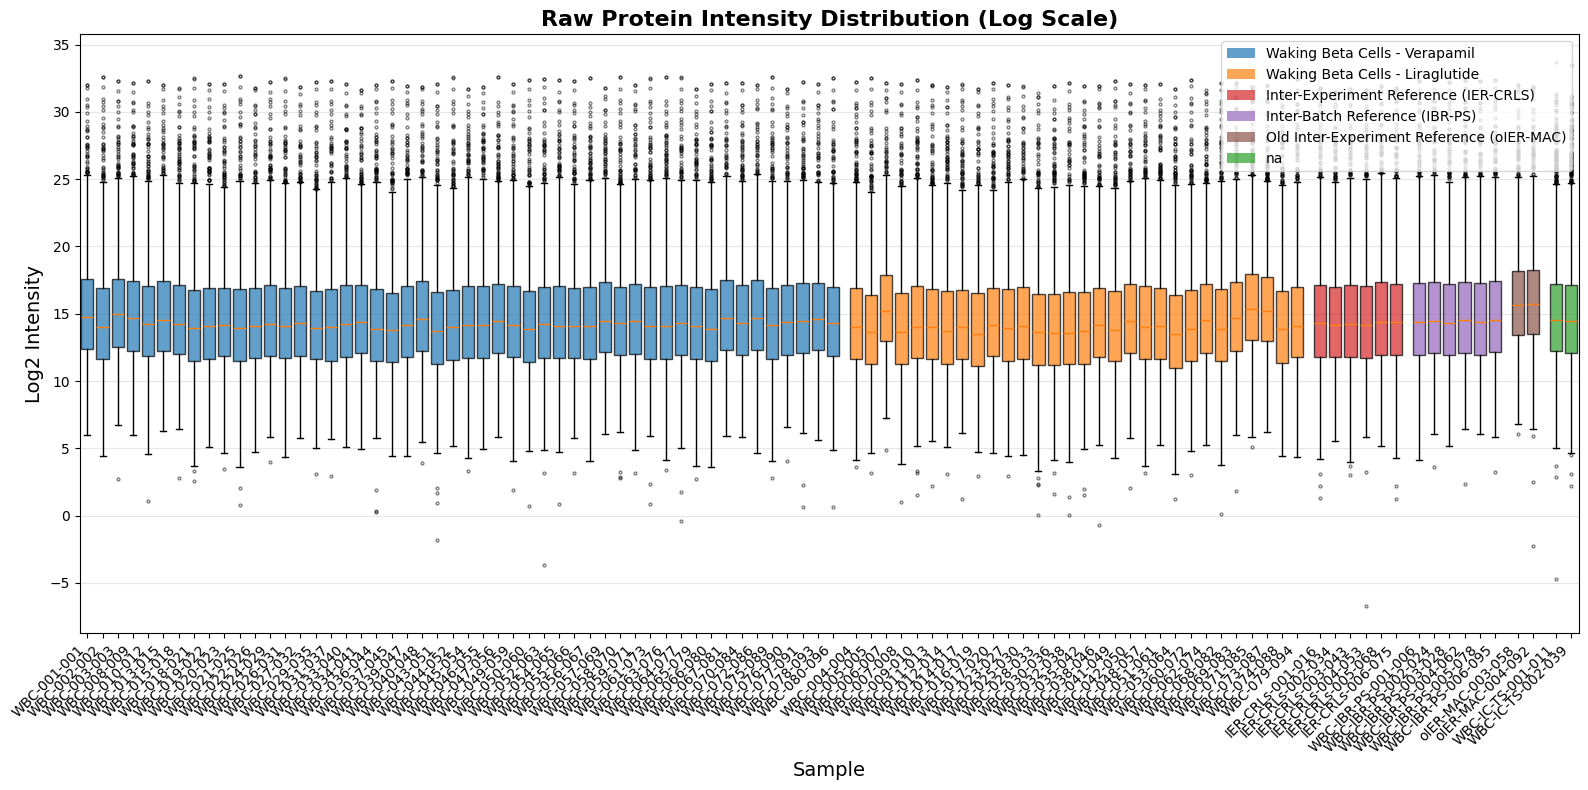

Box plot summary:
Total samples plotted: 96
Average proteins per sample: 2268
✓ Raw data box plot complete


In [9]:
# QC 1: Raw Data Box Plot
import matplotlib.pyplot as plt
plt.close('all')  # Clear any pending figures from previous executions

print("Creating raw data box plot...")

ptk.visualization.plot_box_plot(
    data=standardized_data,
    sample_columns=final_sample_columns,
    sample_metadata=sample_metadata,
    group_colors=group_colors,
    group_order=list(group_distribution.keys()),
    log_transform=True,
    title="Raw Protein Intensity Distribution (Log Scale)"
)

print("✓ Raw data box plot complete")

Creating normalization comparison visualization...


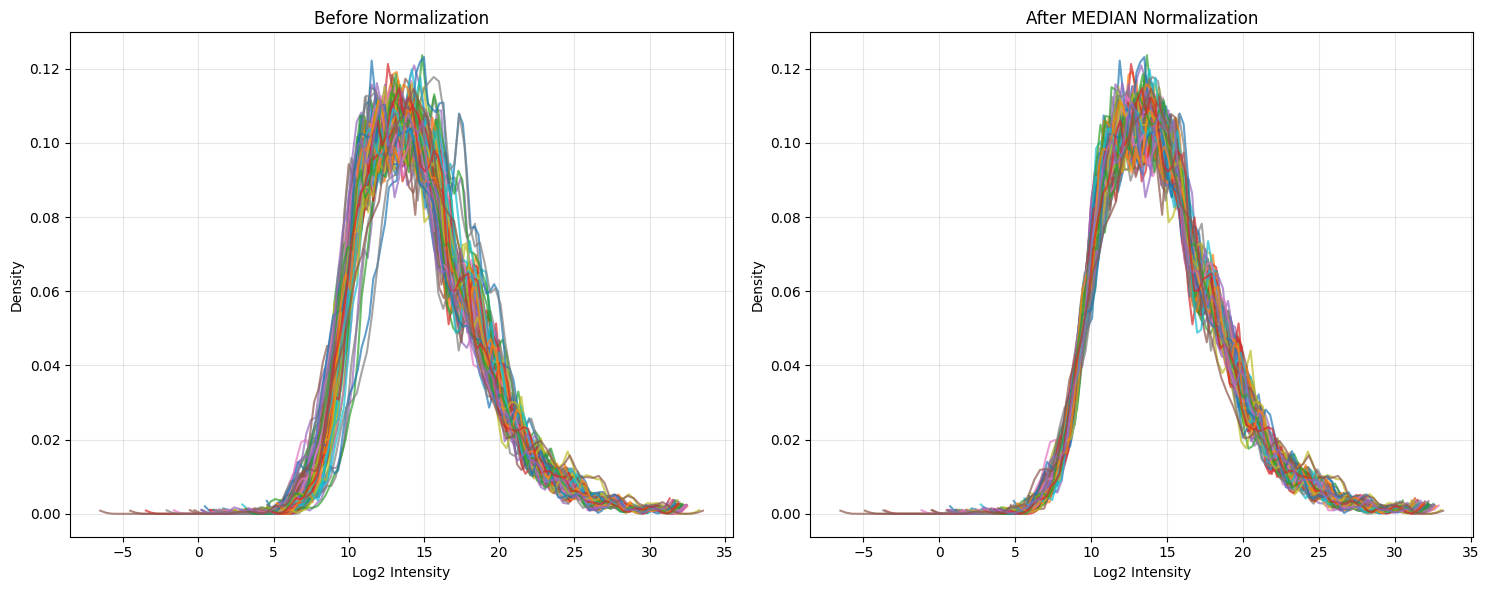

Normalization comparison (MEDIAN):
Original median range: 2.243
Normalized median range: 0.105
Range reduction: 95.3%
✓ Normalization comparison complete


In [10]:
# QC 2: Normalization Comparison Plot
print("Creating normalization comparison visualization...")

ptk.visualization.plot_normalization_comparison(
    original_data=standardized_data[final_sample_columns],
    normalized_data=normalized_data[final_sample_columns],
    sample_columns=final_sample_columns,
    method=normalization_method.upper()
)

print("✓ Normalization comparison complete")

Creating normalized data box plot...
Debug: Group order: ['Waking Beta Cells - Verapamil', 'Waking Beta Cells - Liraglutide', 'Inter-Experiment Reference (IER-CRLS)', 'Inter-Batch Reference (IBR-PS)', 'Old Inter-Experiment Reference (oIER-MAC)', 'na']
Debug: samples_by_group keys: ['Waking Beta Cells - Verapamil', 'Waking Beta Cells - Liraglutide', 'Inter-Experiment Reference (IER-CRLS)', 'Inter-Batch Reference (IBR-PS)', 'Old Inter-Experiment Reference (oIER-MAC)', 'na']
Debug: Total samples to plot: 96
Debug: Final arrays lengths - box_data: 96, positions: 96, colors: 96, labels: 96


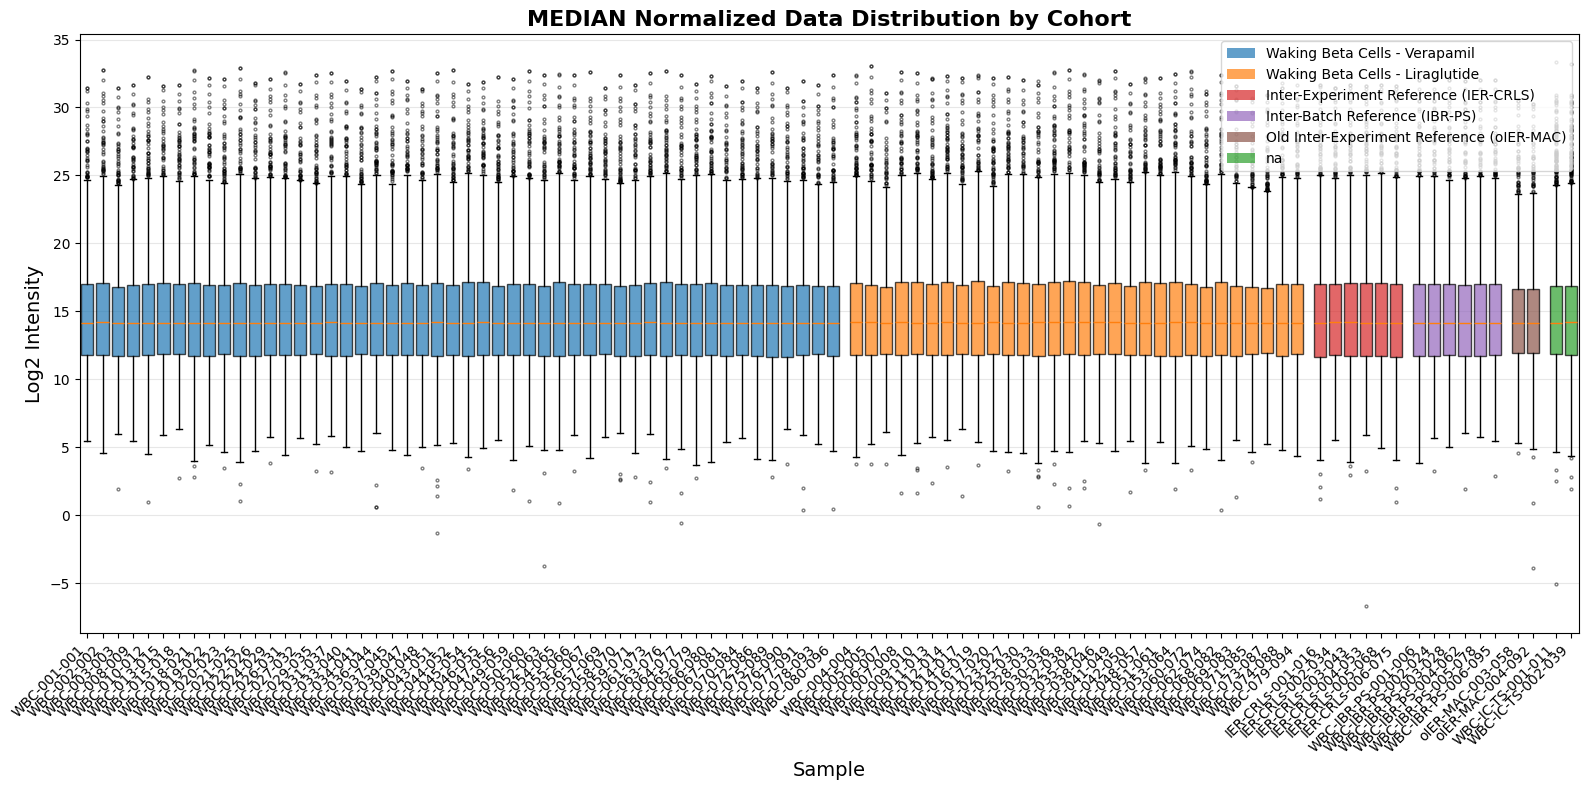

Box plot summary:
Total samples plotted: 96
Average proteins per sample: 2268
✓ Normalized data box plot complete


In [11]:
# QC 3: Normalized Data Box Plot
print("Creating normalized data box plot...")

ptk.visualization.plot_box_plot(
    data=normalized_data,
    sample_columns=final_sample_columns,
    sample_metadata=sample_metadata,
    group_colors=group_colors,
    group_order=list(group_distribution.keys()),
    log_transform=(normalization_method.lower() != 'vsn'),  # VSN data already log-transformed
    title=f"{normalization_method.upper()} Normalized Data Distribution by Cohort"
)

print("✓ Normalized data box plot complete")

Creating comparative PCA analysis...
Applying median normalization...
Median normalization completed for 96 samples
Starting VSN normalization...
Applying VSN transformation to 96 samples...
Processing sample 1/96: WBC-015-018
Processing sample 5/96: WBC-053-064
Processing sample 10/96: WBC-049-059
Processing sample 15/96: IER-CRLs-006-075
Processing sample 20/96: WBC-041-049
Processing sample 25/96: WBC-022-026
Processing sample 30/96: WBC-IBR-PS-004-062
Processing sample 35/96: WBC-073-087
Processing sample 40/96: WBC-058-070
Processing sample 45/96: WBC-002-002
Processing sample 50/96: WBC-003-003
Processing sample 55/96: WBC-044-052
Processing sample 60/96: WBC-057-069
Processing sample 65/96: WBC-048-057
Processing sample 70/96: WBC-072-086
Processing sample 75/96: WBC-068-082
Processing sample 80/96: WBC-008-009
Processing sample 85/96: WBC-026-031
Processing sample 90/96: WBC-027-032
Processing sample 95/96: WBC-028-033
VSN transformation completed!
Performing comparative PCA an

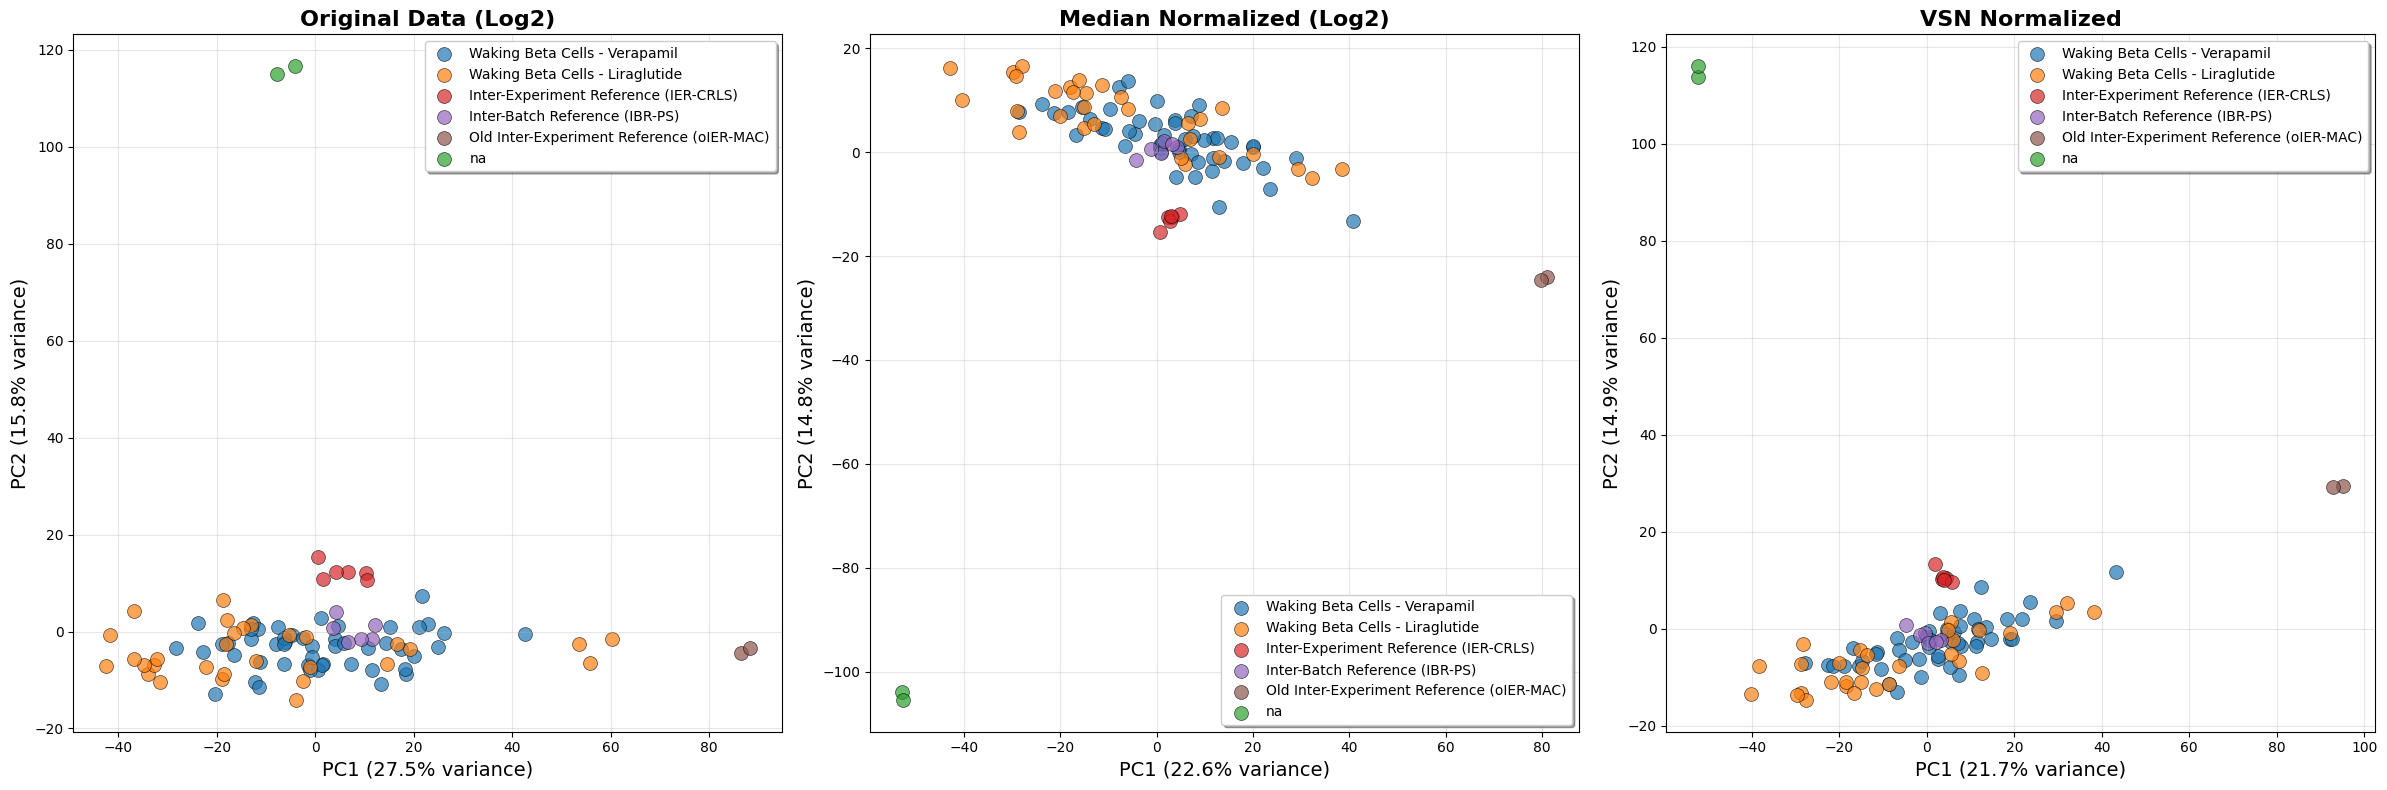


=== PCA SUMMARY STATISTICS ===
**Original Data:**
  PC1 variance: 27.5%
  PC2 variance: 15.8%
  Total variance (PC1-PC2): 43.3%
  Inter-group distance: 69.73 ± 48.16

**Median Normalized:**
  PC1 variance: 22.6%
  PC2 variance: 14.8%
  Total variance (PC1-PC2): 37.4%
  Inter-group distance: 69.07 ± 49.69

**VSN Normalized:**
  PC1 variance: 21.7%
  PC2 variance: 14.9%
  Total variance (PC1-PC2): 36.6%
  Inter-group distance: 76.05 ± 55.46

✓ Comparative PCA analysis complete


In [12]:
# QC 4: Comparative PCA Analysis (Raw, Median, VSN)
print("Creating comparative PCA analysis...")

# Generate comparison normalizations
median_normalized = ptk.normalization.median_normalize(standardized_data, sample_columns=final_sample_columns)
vsn_normalized = ptk.normalization.vsn_normalize(standardized_data, sample_columns=final_sample_columns)

ptk.visualization.plot_comparative_pca(
    original_data=standardized_data,
    median_normalized_data=median_normalized,
    vsn_normalized_data=vsn_normalized,
    sample_columns=final_sample_columns,
    sample_metadata=sample_metadata,
    group_colors=group_colors,
    group_order=list(group_distribution.keys()),
    figsize=(24, 8)
)

print("✓ Comparative PCA analysis complete")

Creating sample correlation heatmap...


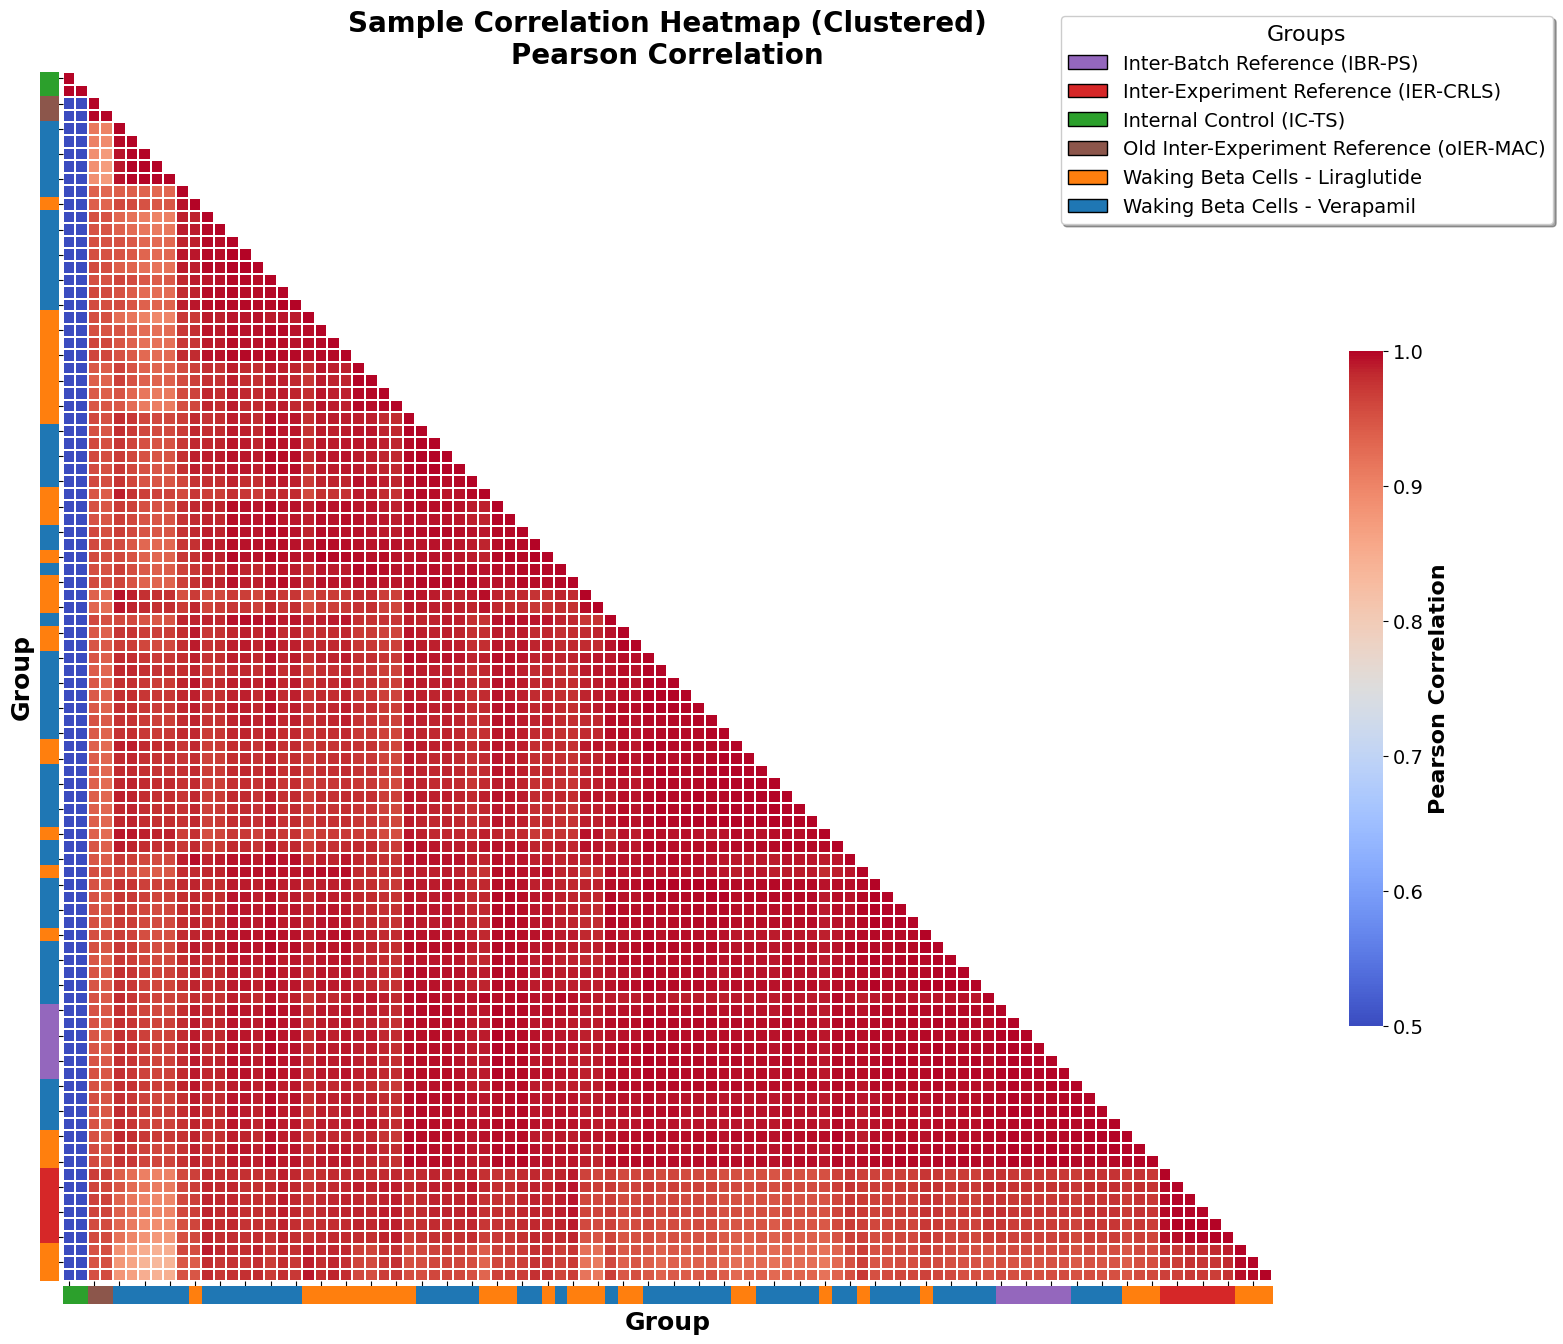


Correlation summary (pearson):
  Mean correlation: 0.942
  Min correlation: 0.044
  Max correlation: 1.000
  Correlation range: 0.956

  Note: Correlation values hidden (96 samples > 30 threshold)

Group composition (by Study):
  Inter-Batch Reference (IBR-PS): 6 samples
  Inter-Experiment Reference (IER-CRLS): 6 samples
  Internal Control (IC-TS): 2 samples
  Old Inter-Experiment Reference (oIER-MAC): 2 samples
  Waking Beta Cells - Liraglutide: 30 samples
  Waking Beta Cells - Verapamil: 50 samples
✓ Sample correlation heatmap complete


In [13]:
# QC 5: Sample Correlation Heatmap
print("Creating sample correlation heatmap...")

ptk.visualization.plot_sample_correlation_triangular_heatmap(
    data=normalized_data,
    sample_columns=final_sample_columns,
    sample_metadata=sample_metadata,
    figsize=(16, 14),
    group_colors=group_colors,
    show_clustering=True
)

print("✓ Sample correlation heatmap complete")

Creating control sample correlation analysis...
=== CONTROL CORRELATION ANALYSIS ===

Looking for control samples in column 'Sample Category' with labels: ['Inter-Experiment Reference (IER-CRLS)', 'Inter-Batch Reference (IBR-PS)', 'Old Inter-Experiment Reference (oIER-MAC)']

Found control samples: ['IER-CRLs-001-016', 'IER-CRLs-005-068', 'IER-CRLs-004-053', 'IER-CRLs-003-043', 'IER-CRLs-006-075', 'WBC-IBR-PS-006-095', 'WBC-IBR-PS-004-062', 'WBC-IBR-PS-003-028', 'WBC-IBR-PS-002-024', 'WBC-IBR-PS-001-006', 'oIER-MAC-003-058', 'WBC-IBR-PS-005-078', 'IER-CRLs-002-034', 'oIER-MAC-004-092']
Total control samples: 14

Creating correlation heatmaps...
Using 2200 proteins for Control Samples Correlation
(Original Data) correlation
Using 2200 proteins for Control Samples Correlation
(Median Normalized) correlation
Using 2200 proteins for Control Samples Correlation
(Median Normalized) correlation
Using 2280 proteins for Control Samples Correlation
(VSN Normalized) correlation
Using 2280 protein

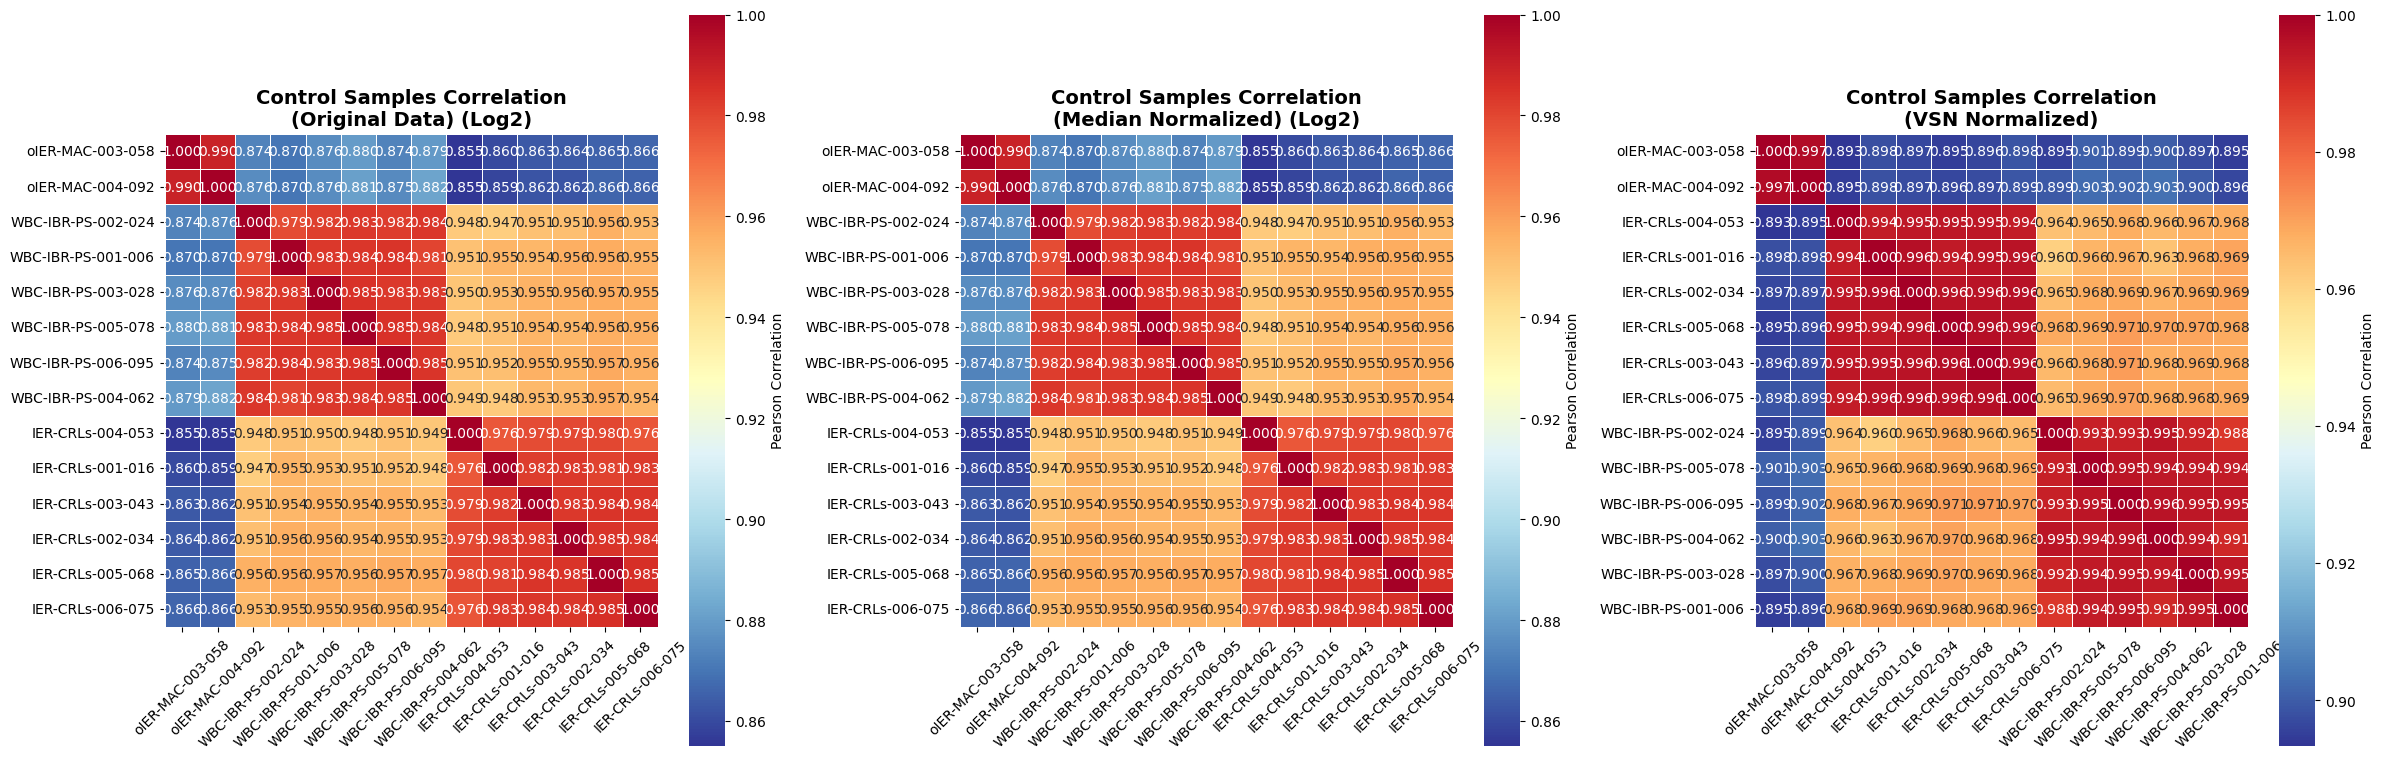


=== CONTROL CORRELATION SUMMARY ===

**Original Data:**
  Mean correlation: 0.941
  Median correlation: 0.955
  Min correlation: 0.855
  Max correlation: 0.990
  High correlation (>0.8): 91/91 (100.0%)

**Median Normalized:**
  Mean correlation: 0.941
  Median correlation: 0.955
  Min correlation: 0.855
  Max correlation: 0.990
  High correlation (>0.8): 91/91 (100.0%)

**VSN Normalized:**
  Mean correlation: 0.958
  Median correlation: 0.968
  Min correlation: 0.893
  Max correlation: 0.997
  High correlation (>0.8): 91/91 (100.0%)
✓ Control sample correlation analysis complete


In [14]:
# QC 6: Control Sample Correlation Analysis
print("Creating control sample correlation analysis...")

# Use the pre-generated normalizations from PCA cell
ptk.visualization.plot_control_correlation_analysis(
    original_data=standardized_data,
    median_normalized_data=median_normalized,
    vsn_normalized_data=vsn_normalized,
    sample_columns=final_sample_columns,
    sample_metadata=sample_metadata,
    control_column=control_column,
    control_labels=control_labels,
    figsize=(24, 8)
)

print("✓ Control sample correlation analysis complete")

Creating control sample CV distribution plots...
=== CONTROL SAMPLE CV DISTRIBUTION ANALYSIS ===
Control samples by type:
  Inter-Experiment Reference (IER-CRLS): 6 samples
  Inter-Batch Reference (IBR-PS): 6 samples
  Old Inter-Experiment Reference (oIER-MAC): 2 samples
  Inter-Experiment Reference (IER-CRLS): 2280 proteins with calculable CV
  Inter-Batch Reference (IBR-PS): 2280 proteins with calculable CV
  Old Inter-Experiment Reference (oIER-MAC): 2280 proteins with calculable CV

Inter-Experiment Reference (IER-CRLS) Statistics:
  Median CV: 19.63%
  Mean CV: 27.22%
  Proteins with CV < 20.0%: 51.0%
  Proteins with CV < 10%: 23.0%

Inter-Batch Reference (IBR-PS) Statistics:
  Median CV: 18.92%
  Mean CV: 25.61%
  Proteins with CV < 20.0%: 51.6%
  Proteins with CV < 10%: 23.2%

Old Inter-Experiment Reference (oIER-MAC) Statistics:
  Median CV: 8.69%
  Mean CV: 16.05%
  Proteins with CV < 20.0%: 75.2%
  Proteins with CV < 10%: 55.3%


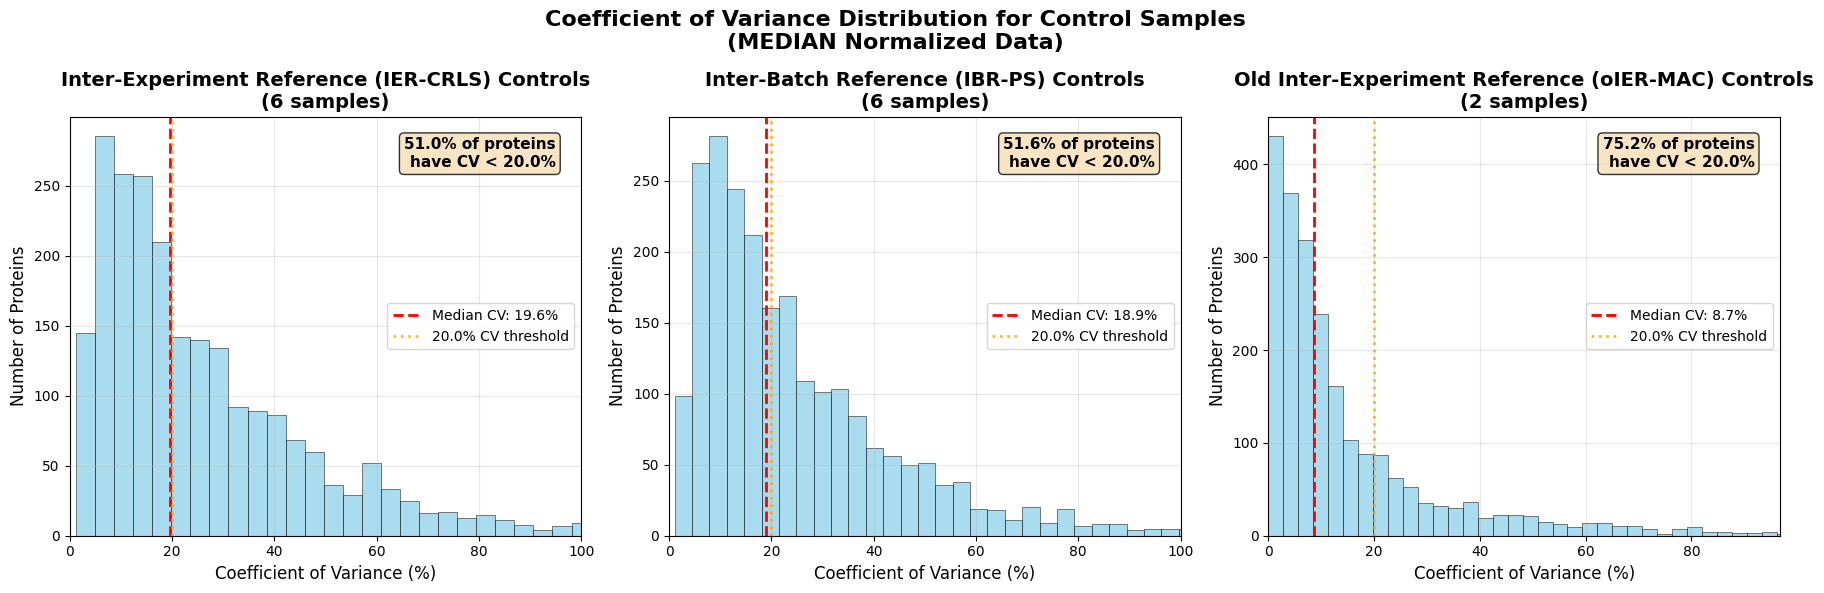


✓ Control sample CV distribution analysis complete
Note: CV calculated from median normalized (non-log transformed) data
Lower CV values indicate better reproducibility between control replicates
✓ Control sample CV distribution complete


In [15]:
# QC 7: Control Sample CV Distribution
print("Creating control sample CV distribution plots...")

# Use the user-selected normalized data for CV analysis
ptk.visualization.plot_control_cv_distribution(
    data=normalized_data,
    sample_columns=final_sample_columns,
    sample_metadata=sample_metadata,
    control_column=control_column,
    control_labels=control_labels,
    normalization_method=normalization_method.upper(),
    figsize=(18, 6),
    cv_threshold=20.0,
    title_suffix=""
)

print("✓ Control sample CV distribution complete")

Creating individual control pool correlation analysis...

=== INDIVIDUAL CONTROL POOL CORRELATION ANALYSIS (MEDIAN) ===

Analyzing 3 control pools:
  Inter-Experiment Reference (IER-CRLS): 6 samples - ['IER-CRLs-001-016', 'IER-CRLs-005-068', 'IER-CRLs-004-053', 'IER-CRLs-003-043', 'IER-CRLs-006-075', 'IER-CRLs-002-034']
  Inter-Batch Reference (IBR-PS): 6 samples - ['WBC-IBR-PS-006-095', 'WBC-IBR-PS-004-062', 'WBC-IBR-PS-003-028', 'WBC-IBR-PS-002-024', 'WBC-IBR-PS-001-006', 'WBC-IBR-PS-005-078']
  Old Inter-Experiment Reference (oIER-MAC): 2 samples - ['oIER-MAC-003-058', 'oIER-MAC-004-092']

--- Inter-Experiment Reference (IER-CRLS) Correlation Analysis ---
Using 2220 proteins for Inter-Experiment Reference (IER-CRLS)


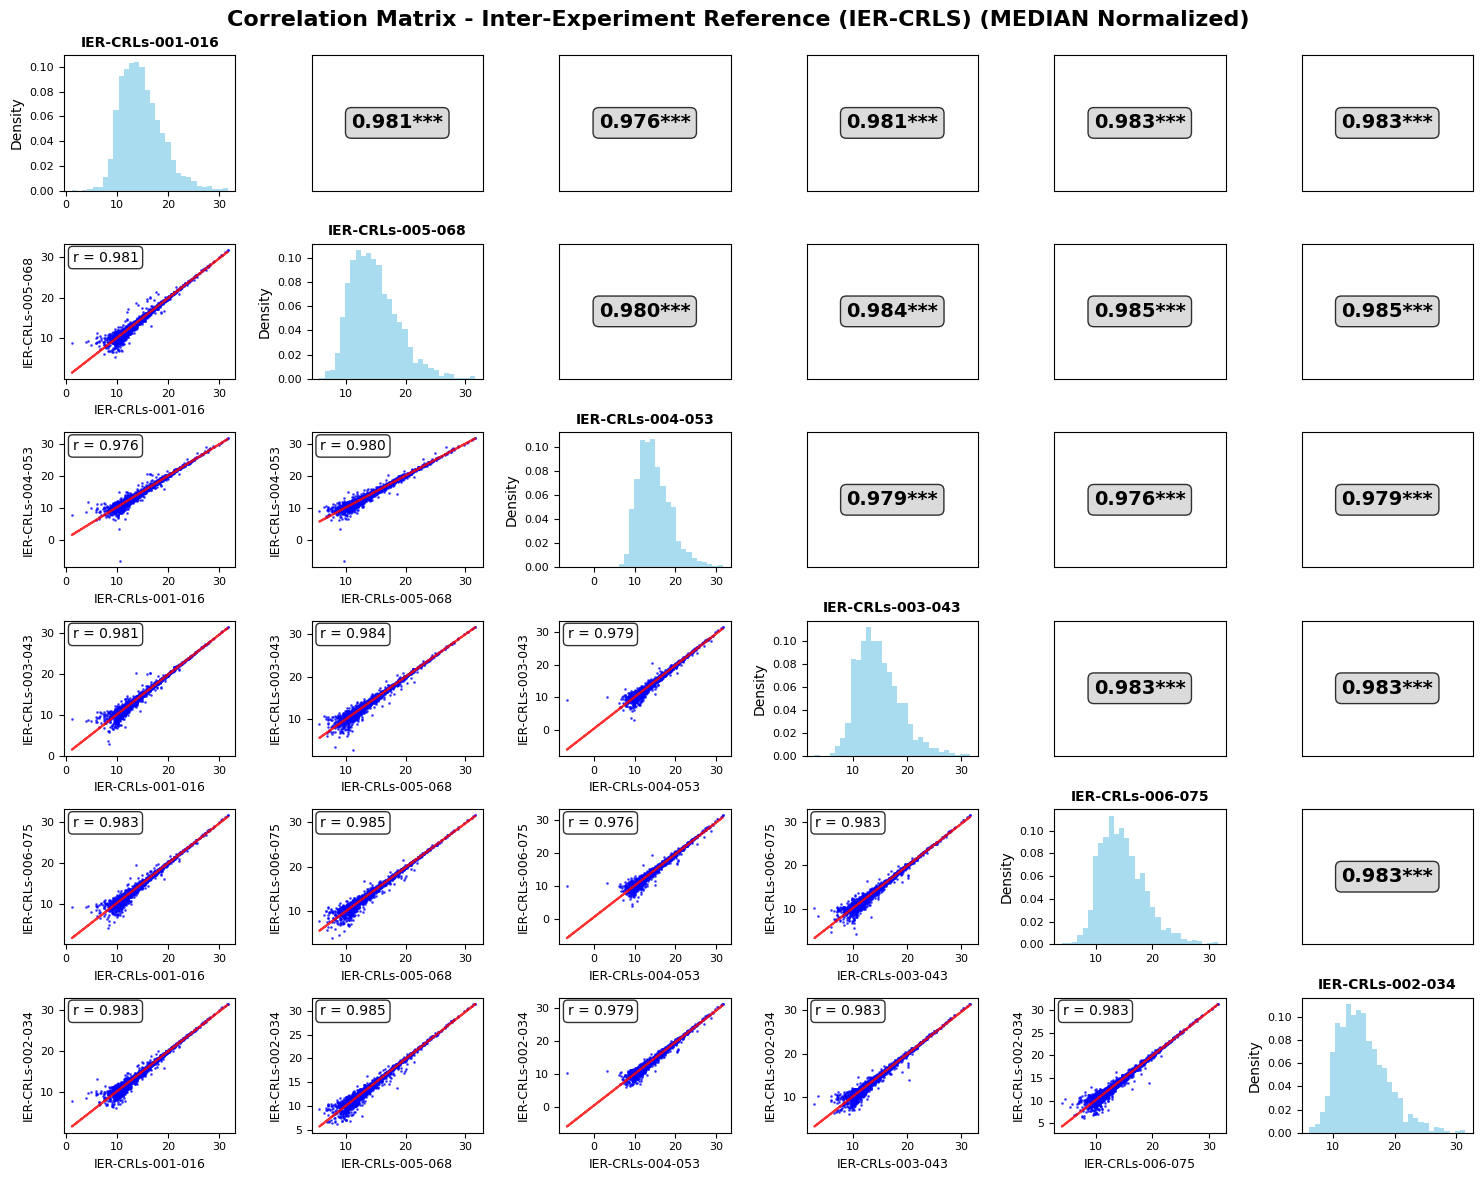


Inter-Experiment Reference (IER-CRLS) Correlation Summary:
  Mean correlation: 0.981
  Median correlation: 0.983
  Min correlation: 0.976
  Max correlation: 0.985
  High correlation (>0.9): 15/15 (100.0%)

Inter-Experiment Reference (IER-CRLS) analysis complete!
--------------------------------------------------

--- Inter-Batch Reference (IBR-PS) Correlation Analysis ---
Using 2251 proteins for Inter-Batch Reference (IBR-PS)


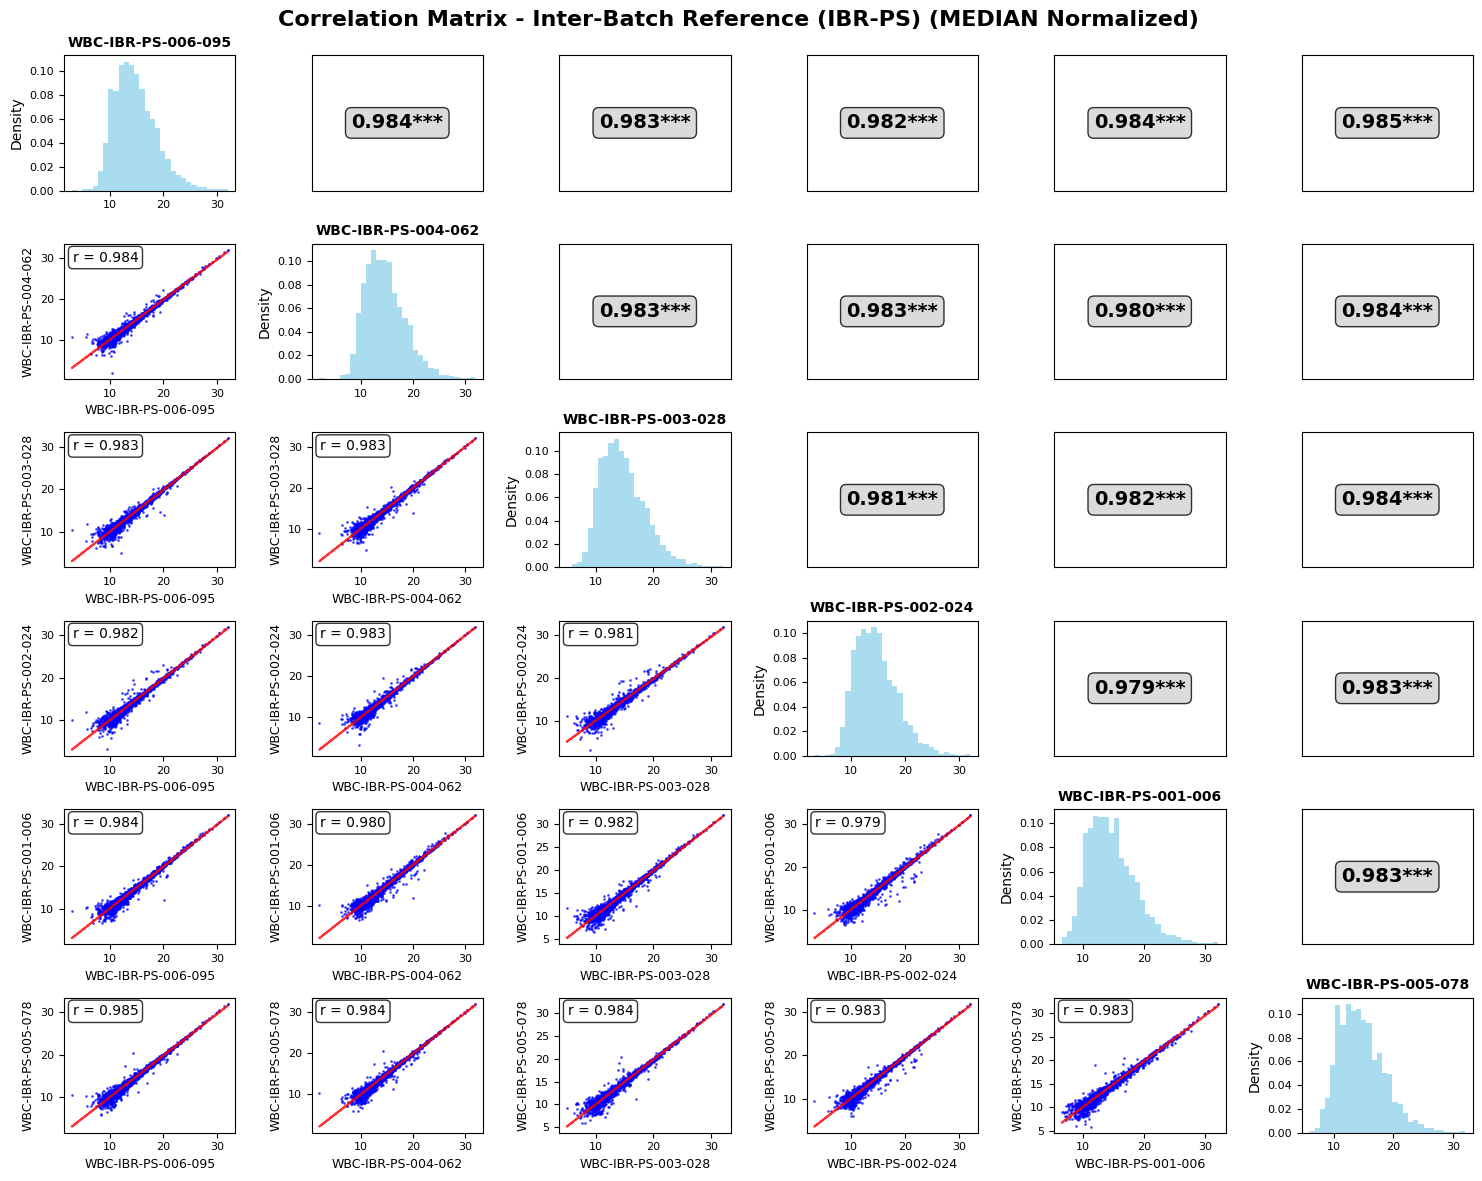


Inter-Batch Reference (IBR-PS) Correlation Summary:
  Mean correlation: 0.983
  Median correlation: 0.983
  Min correlation: 0.979
  Max correlation: 0.985
  High correlation (>0.9): 15/15 (100.0%)

Inter-Batch Reference (IBR-PS) analysis complete!
--------------------------------------------------

--- Old Inter-Experiment Reference (oIER-MAC) Correlation Analysis ---
Using 2271 proteins for Old Inter-Experiment Reference (oIER-MAC)


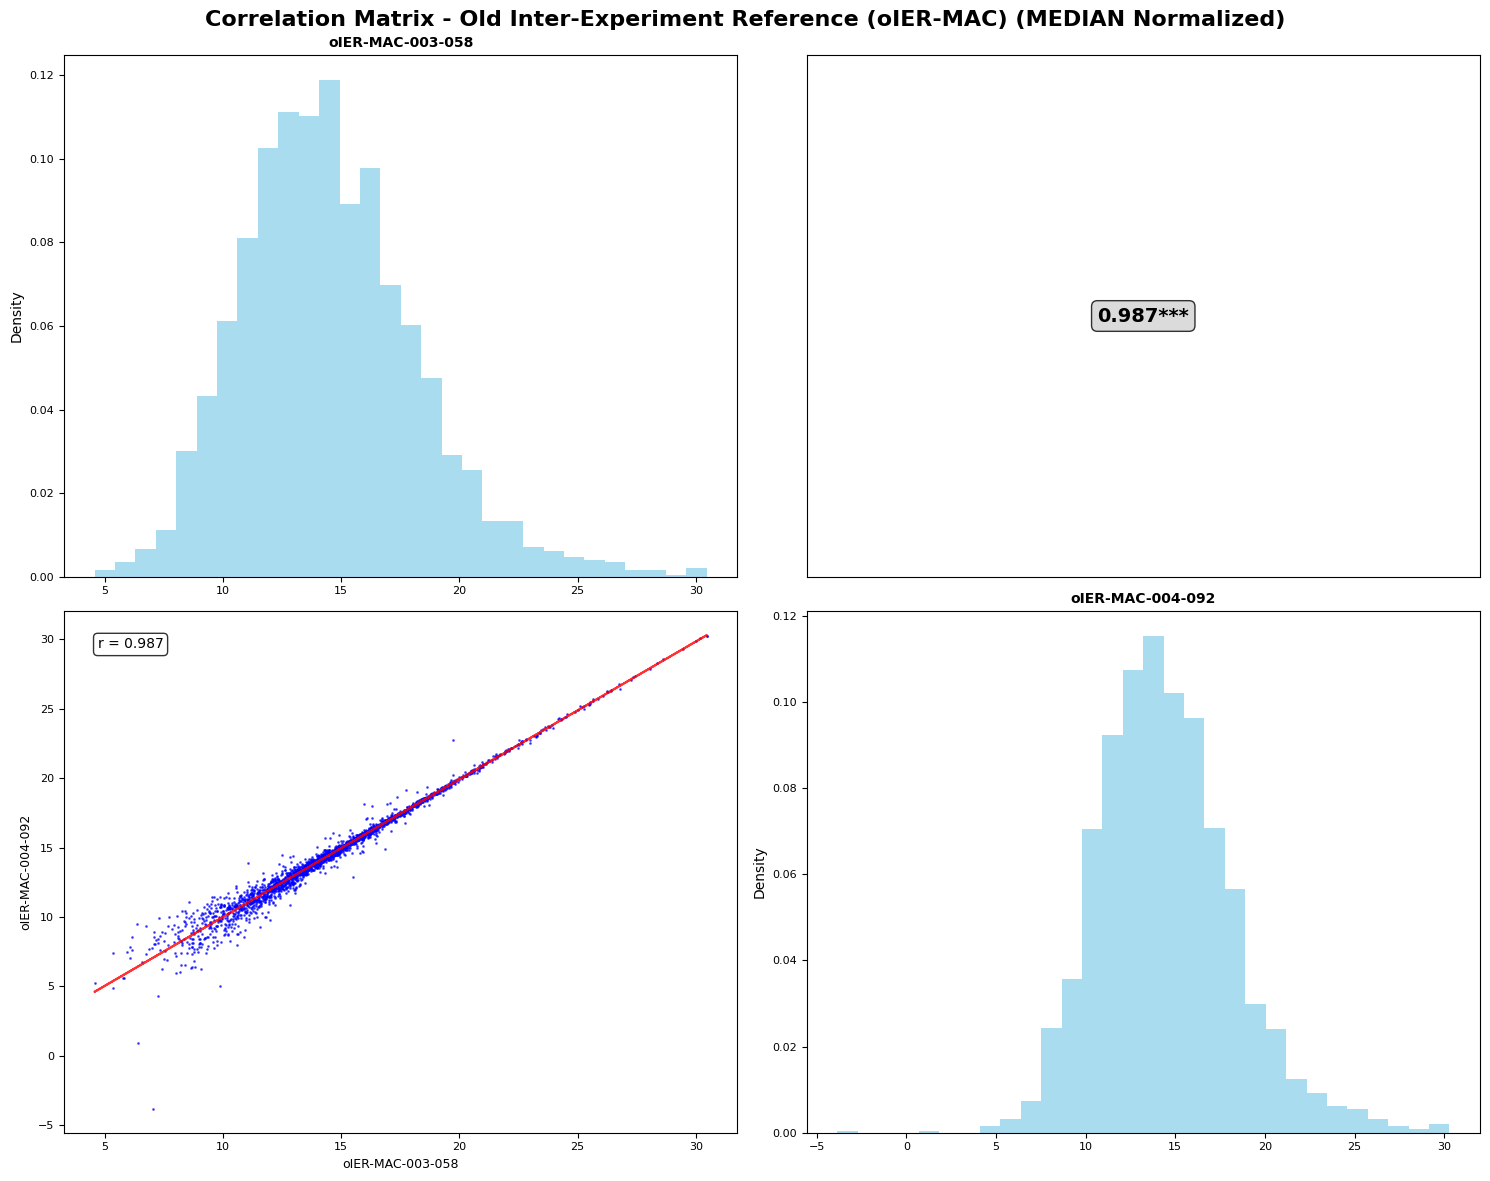


Old Inter-Experiment Reference (oIER-MAC) Correlation Summary:
  Mean correlation: 0.987
  Median correlation: 0.987
  Min correlation: 0.987
  Max correlation: 0.987
  High correlation (>0.9): 1/1 (100.0%)

Old Inter-Experiment Reference (oIER-MAC) analysis complete!
--------------------------------------------------
✓ Individual control pool analysis complete

DATA QC COMPLETE - All quality control visualizations generated


In [16]:
# QC 8: Individual Control Pool Analysis
print("Creating individual control pool correlation analysis...")

ptk.visualization.plot_individual_control_pool_analysis(
    data=normalized_data,
    sample_columns=final_sample_columns,
    sample_metadata=sample_metadata,
    control_column=control_column,
    control_labels=control_labels,
    normalization_method=normalization_method.upper(),
    figsize=(15, 12)
)

print("✓ Individual control pool analysis complete")
print("\n" + "="*80)
print("DATA QC COMPLETE - All quality control visualizations generated")
print("="*80)

In [17]:
# ============================================================================
# VERAPAMIL ANALYSIS
# ============================================================================

print("="*80)
print("ANALYSIS 1: VERAPAMIL LONGITUDINAL ANALYSIS")
print("="*80)

# Filter to Verapamil samples only
verapamil_samples = [
    s for s, m in sample_metadata.items() 
    if m.get('Study') == 'Waking Beta Cells - Verapamil'
]

print(f"\nVerapamil samples: {len(verapamil_samples)}")

# Show subject and timepoint distribution
verapamil_metadata = {s: sample_metadata[s] for s in verapamil_samples}
subjects = set([m.get('BRI Subject ID') for m in verapamil_metadata.values() if m.get('BRI Subject ID')])
print(f"Unique subjects: {len(subjects)}")

weeks = [m.get('Week') for m in verapamil_metadata.values()]
week_counts = pd.Series(weeks).value_counts().sort_index()
print("\nTimepoint distribution:")
for week, count in week_counts.items():
    print(f"  Week {week}: {count} samples")

# ============================================================================
# CONFIGURE STATISTICAL ANALYSIS
# ============================================================================
config_verapamil = ptk.statistical_analysis.StatisticalConfig()

# Analysis type and method
# Options: "linear_trend" (tests slope != 0) or "longitudinal" (F-test for any change)
config_verapamil.analysis_type = "longitudinal"  # F-test for ANY change over time
config_verapamil.statistical_test_method = statistical_test_method

# Experimental design
config_verapamil.subject_column = subject_column  # "BRI Subject ID"
config_verapamil.time_column = "Week"  # Week as categorical time variable

# NO COVARIATES - Age/Sex are between-subject and confound with random intercept
config_verapamil.covariates = []  # Removed to avoid confounding with (1|Subject)

# Significance thresholds
config_verapamil.p_value_threshold = p_value_threshold
config_verapamil.fold_change_threshold = fold_change_threshold

# Log transformation settings
config_verapamil.log_transform_before_stats = log_transform_before_stats
config_verapamil.log_base = log_base
config_verapamil.log_pseudocount = log_pseudocount
config_verapamil.normalization_method = normalization_method.lower()

# P-value settings
config_verapamil.use_adjusted_pvalue = use_adjusted_pvalue
config_verapamil.enable_pvalue_fallback = enable_pvalue_fallback

# ============================================================================

print("\nRunning mixed-effects longitudinal analysis for Verapamil...")
print("Model: Protein ~ C(Week) + (1|BRI Subject ID)")
print("Tests: Do ANY timepoints differ? (F-test on time as categorical factor)")
print("Note: Age/Sex absorbed into subject random effects (each subject is their own control)")

# Run analysis
verapamil_results = ptk.statistical_analysis.run_comprehensive_statistical_analysis(
    normalized_data=normalized_data,
    sample_metadata=verapamil_metadata,
    config=config_verapamil,
    protein_annotations=filtered_data
)

# Display summary
print("\n" + "="*80)
print("VERAPAMIL RESULTS SUMMARY")
print("="*80)
verapamil_summary = ptk.statistical_analysis.display_analysis_summary(
    differential_results=verapamil_results,
    config=config_verapamil,
    label_top_n=label_top_proteins
)

print(f"\n✓ Verapamil analysis complete: {len(verapamil_results)} proteins analyzed")
display(verapamil_results[['Gene', 'Protein', 'logFC', 'P.Value', 'adj.P.Val']].head(20))

ANALYSIS 1: VERAPAMIL LONGITUDINAL ANALYSIS

Verapamil samples: 50
Unique subjects: 10

Timepoint distribution:
  Week 0.0: 10 samples
  Week 2.0: 10 samples
  Week 4.0: 10 samples
  Week 6.0: 10 samples
  Week 12.0: 10 samples

Running mixed-effects longitudinal analysis for Verapamil...
Model: Protein ~ C(Week) + (1|BRI Subject ID)
Tests: Do ANY timepoints differ? (F-test on time as categorical factor)
Note: Age/Sex absorbed into subject random effects (each subject is their own control)
COMPREHENSIVE STATISTICAL ANALYSIS
Log transformation: AUTO-DETECTED (needed - median preserves original scale)
Applying log2 transformation for statistical analysis...
  -> Applied log2 transformation with pseudocount 0.1
  -> New data range: -3.32 to 33.38
  -> New mean: 14.57
Step 1: Cleaning and validating sample metadata...
  Using standardized data structure: 96 sample columns (columns 6+)
  Filtered to 50 samples with metadata (from 96 total)
  Sample columns: ['WBC-015-018', 'WBC-050-060', 'W

Gene                Protein     logFC   P.Value  adj.P.Val
256       FNDC1  sp|Q4ZHG4|FNDC1_HUMAN  0.548116  0.000094   0.101900
581   SERPINA10    sp|Q9UK55|ZPI_HUMAN  0.358291  0.000098   0.101900
476        LIPC   sp|P11150|LIPC_HUMAN  0.258485  0.000134   0.101900
1321    ANGPTL8  sp|Q6UXH0|ANGL8_HUMAN -1.172288  0.000317   0.109339
941      IGFALS    sp|P35858|ALS_HUMAN  0.323774  0.000417   0.109339
811       CLDN5   sp|O00501|CLD5_HUMAN -0.617039  0.000442   0.109339
766      TGOLN2  sp|O43493|TGON2_HUMAN  0.692527  0.000451   0.109339
2248       OIT3   sp|Q8WWZ8|OIT3_HUMAN  0.542823  0.000554   0.109339
433     ANGPTL3  sp|Q9Y5C1|ANGL3_HUMAN -0.413401  0.000568   0.109339
391     SLC25A6   sp|P12236|ADT3_HUMAN  0.411249  0.000609   0.109339
451     SLC25A5   sp|P05141|ADT2_HUMAN -0.435365  0.000624   0.109339
1979      SFXN1  sp|Q9H9B4|SFXN1_HUMAN -0.455182  0.000643   0.109339
1392      PSMD6  sp|Q15008|PSMD6_HUMAN  0.791598  0.000677   0.109339
322    C16orf54  sp|Q6UWD8|CP054_HUMAN  0.492984  0.000680   0.109339
306       PRSS2   sp|P07478|TRY2_HUMAN  0.529322  0.000719   0.109339
75      ANGPTL6  sp|Q8NI99|ANGL6_HUMAN  0.389434  0.000917   0.123111
37        COPS3   sp|Q9UNS2|CSN3_HUMAN  0.818648  0.001034   0.123111
57        PPP6C   sp|O00743|PPP6_HUMAN  0.649350  0.001093   0.123111
1895      APOC2  sp|P02655|APOC2_HUMAN  0.414859  0.001126   0.123111
1931   SERPINA5   sp|P05154|IPSP_HUMAN -0.679022  0.001181   0.123111

Creating Verapamil volcano plot...
⚠️  No significant proteins found using adjusted p-values (FDR < 0.05)
📊 Automatically falling back to unadjusted p-values for visualization
    Note: Results shown use raw p-values, interpret with caution

Verapamil Longitudinal Analysis: Proteins Changing Over Time

Verapamil Longitudinal Analysis: Proteins Changing Over Time


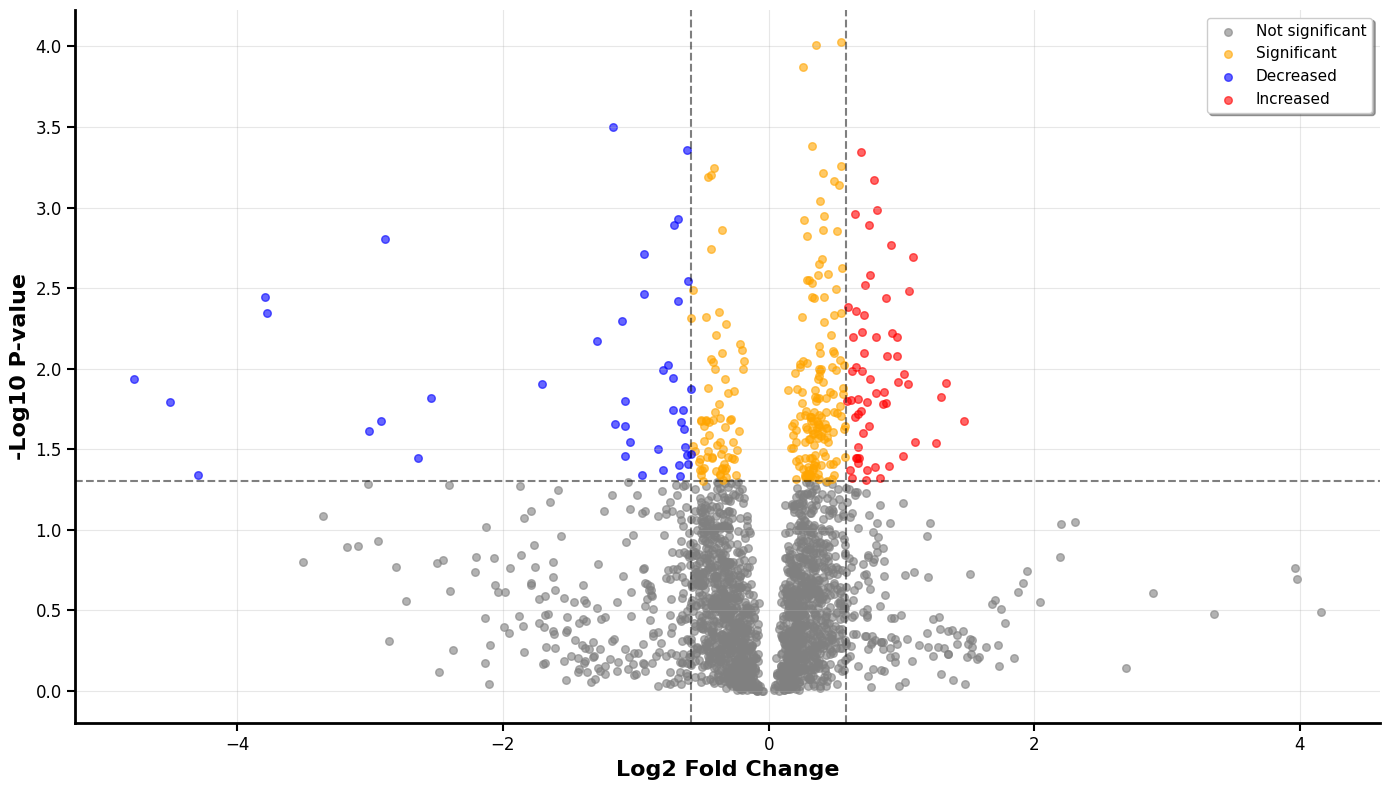

Volcano plot summary:
Total proteins: 2280
P-value type used: P-value (fallback from FDR)
Significant (P-value < 0.05): 327
Up-regulated (FC > 0.5849625007211562, P-value < 0.05): 60
Down-regulated (FC < -0.5849625007211562, P-value < 0.05): 43


In [18]:
# Volcano Plot for Verapamil
print("Creating Verapamil volcano plot...")

ptk.visualization.plot_volcano(
    differential_df=verapamil_results,
    fc_threshold=fold_change_threshold,
    p_threshold=p_value_threshold,
    figsize=(14, 8),
    title='Verapamil Longitudinal Analysis: Proteins Changing Over Time',
    label_top_n=label_top_proteins,
    use_adjusted_pvalue=use_adjusted_pvalue,
    enable_pvalue_fallback=enable_pvalue_fallback,
    normalization_method=normalization_method
)

Found protein: CHGA (sp|P10645|CMGA_HUMAN)


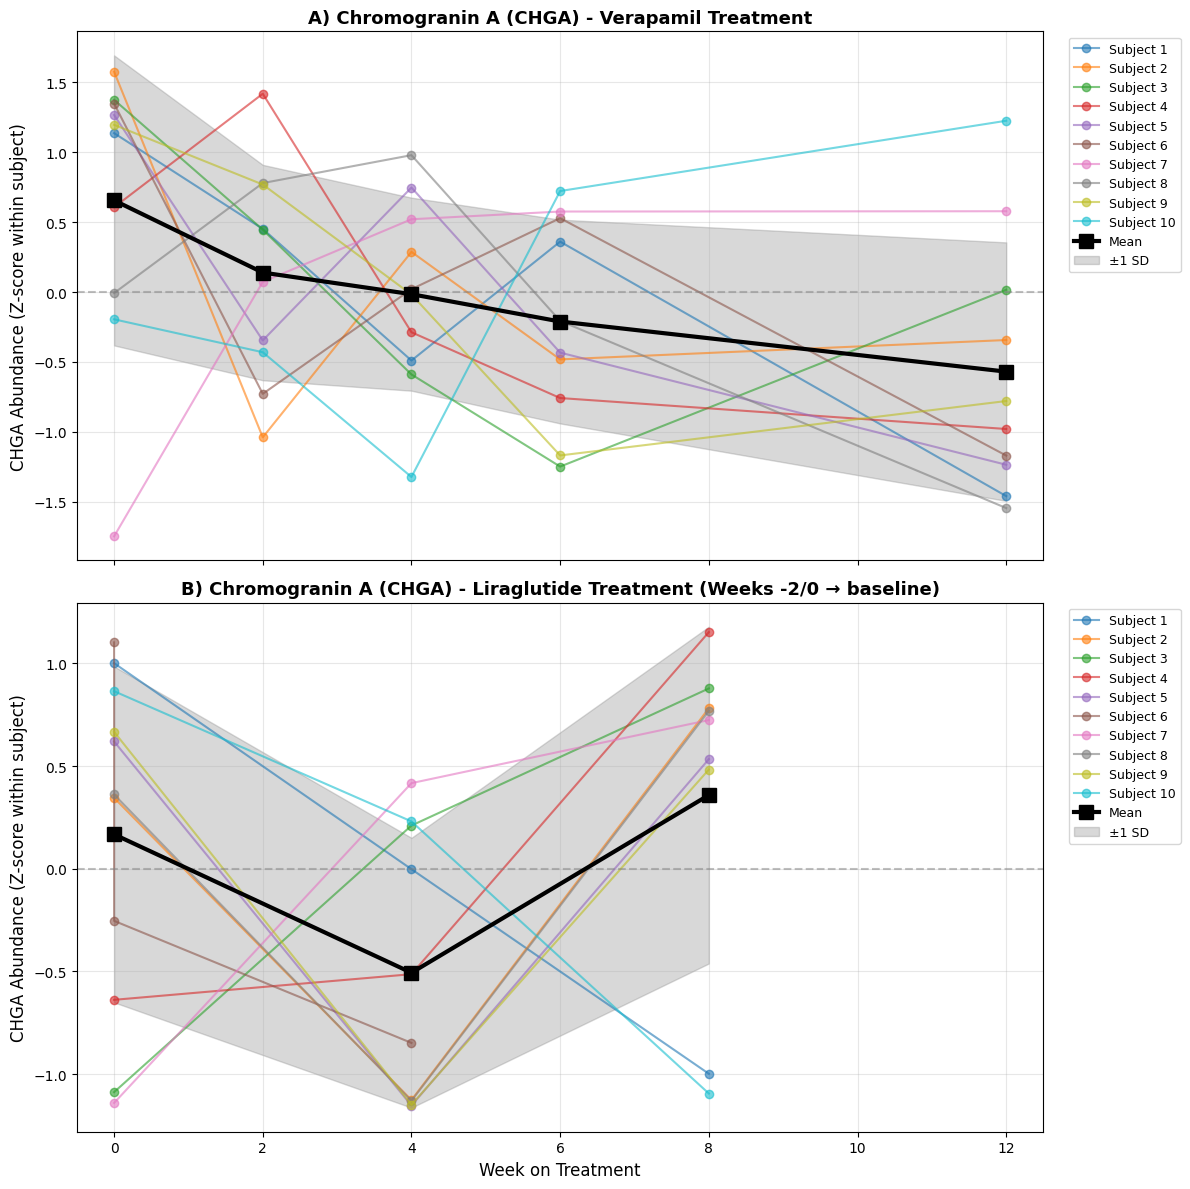


CHGA Statistics by Timepoint (Z-scored within subject, ± SD shown)

📊 VERAPAMIL:
 Week      Mean       SD  N
    0  0.655914 1.037739 10
    2  0.139551 0.770642 10
    4 -0.015130 0.690658 10
    6 -0.210910 0.729085 10
   12 -0.569426 0.924912 10

📊 LIRAGLUTIDE (Weeks -2 and 0 pooled as baseline):
 Week      Mean       SD  N
    0  0.167239 0.818261 11
    4 -0.506796 0.657209 10
    8  0.358703 0.820296  9

📈 CHGA in Verapamil longitudinal analysis:
   logFC (max change): -0.581
   P-value: 0.0048
   Adjusted P-value: 0.1753


In [19]:
# =============================================================================
# CHGA (Chromogranin A) Temporal Profile - Verapamil & Liraglutide
# =============================================================================
# CHGA has been shown to change with verapamil treatment in previous studies
# Reference: Ovalle et al. (2018) Nat Med. https://pmc.ncbi.nlm.nih.gov/articles/PMC8894430/

import matplotlib.pyplot as plt

# Define Liraglutide samples/metadata - always compute fresh to include all samples (including Week 0)
# This cell can run before or after the Liraglutide analysis cell
liraglutide_samples_chga = [
    s for s, m in sample_metadata.items() 
    if m.get('Study') == 'Waking Beta Cells - Liraglutide'
]
liraglutide_metadata_chga = {s: sample_metadata[s] for s in liraglutide_samples_chga}

# Find CHGA protein in filtered_data (which has Gene column)
chga_mask = filtered_data['Gene'].str.upper() == 'CHGA'
if chga_mask.sum() == 0:
    # Try alternative names
    chga_mask = filtered_data['Gene'].str.contains('CHGA|chromogranin', case=False, na=False)

if chga_mask.sum() > 0:
    # Get protein identifier from filtered_data
    chga_filtered_row = filtered_data[chga_mask].iloc[0]
    chga_protein = chga_filtered_row['Protein'] if 'Protein' in chga_filtered_row else chga_filtered_row.name
    chga_gene = chga_filtered_row['Gene'] if 'Gene' in chga_filtered_row else 'CHGA'
    
    print(f"Found protein: {chga_gene} ({chga_protein})")
    
    # Find the matching row in normalized_data using Protein identifier
    if 'Protein' in normalized_data.columns:
        chga_norm_mask = normalized_data['Protein'] == chga_protein
    else:
        chga_norm_mask = normalized_data.index == chga_filtered_row.name
    
    if chga_norm_mask.sum() > 0:
        chga_row = normalized_data[chga_norm_mask].iloc[0]
    else:
        chga_idx = filtered_data[chga_mask].index[0]
        if chga_idx in normalized_data.index:
            chga_row = normalized_data.loc[chga_idx]
        else:
            chga_row = normalized_data.iloc[filtered_data.index.get_loc(chga_idx)]
    
    # Helper function to extract CHGA data for a treatment
    def extract_chga_data(sample_list, metadata_dict, treatment_name):
        sample_cols = [s for s in sample_list if s in normalized_data.columns]
        data = []
        for sample in sample_cols:
            meta = metadata_dict[sample]
            subject = meta.get('BRI Subject ID')
            week = meta.get('Week')
            value = chga_row[sample]
            if pd.notna(value) and pd.notna(subject) and pd.notna(week):
                data.append({
                    'Subject': subject,
                    'Week': int(week),
                    'Abundance': np.log2(value) if value > 0 else np.nan
                })
        return pd.DataFrame(data)
    
    # Z-score normalize WITHIN each subject
    def zscore_within_subject(group):
        mean_val = group['Abundance'].mean()
        std_val = group['Abundance'].std()
        if std_val > 0:
            group['Z_Score'] = (group['Abundance'] - mean_val) / std_val
        else:
            group['Z_Score'] = 0
        return group
    
    # Extract and process Verapamil data
    chga_verapamil = extract_chga_data(verapamil_samples, verapamil_metadata, 'Verapamil')
    chga_verapamil = chga_verapamil.groupby('Subject', group_keys=False).apply(zscore_within_subject)
    chga_verapamil = chga_verapamil.sort_values(['Subject', 'Week'])
    
    # Extract and process Liraglutide data (using local variables)
    chga_liraglutide = extract_chga_data(liraglutide_samples_chga, liraglutide_metadata_chga, 'Liraglutide')
    # Map weeks -2 and 0 to baseline (week 0)
    chga_liraglutide['Week_Original'] = chga_liraglutide['Week']
    chga_liraglutide['Week'] = chga_liraglutide['Week'].replace({-2: 0})
    chga_liraglutide = chga_liraglutide.groupby('Subject', group_keys=False).apply(zscore_within_subject)
    chga_liraglutide = chga_liraglutide.sort_values(['Subject', 'Week'])
    
    # Function to calculate stats with SE instead of SD
    def calc_timepoint_stats(df):
        stats = df.groupby('Week')['Z_Score'].agg(['mean', 'std', 'count']).reset_index()
        stats.columns = ['Week', 'Mean', 'SD', 'N']
        stats['SE'] = stats['SD'] / np.sqrt(stats['N'])
        return stats
    
    verap_stats = calc_timepoint_stats(chga_verapamil)
    lirag_stats = calc_timepoint_stats(chga_liraglutide)
    
    # Create 2-panel figure with SHARED x-axis scale (0-12 weeks)
    # This allows visual comparison: Week 4 aligns between panels
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
    
    # Set common x-axis limits (0-12 weeks to match Verapamil range)
    x_min, x_max = -0.5, 12.5
    
    # --- Panel 1: Verapamil ---
    subjects_v = chga_verapamil['Subject'].unique()
    colors_v = plt.cm.tab10(np.linspace(0, 1, len(subjects_v)))
    
    for i, subject in enumerate(subjects_v):
        subj_data = chga_verapamil[chga_verapamil['Subject'] == subject].sort_values('Week')
        ax1.plot(subj_data['Week'], subj_data['Z_Score'], 
                marker='o', markersize=6, linewidth=1.5, alpha=0.6,
                color=colors_v[i], label=f'Subject {i+1}')
    
    # Mean line
    ax1.plot(verap_stats['Week'], verap_stats['Mean'], 
            color='black', linewidth=3, marker='s', markersize=10,
            label='Mean', zorder=10)
    
    # SD ribbon (consistent with Z-score scale which is based on SD)
    ax1.fill_between(verap_stats['Week'], 
                    verap_stats['Mean'] - verap_stats['SD'],
                    verap_stats['Mean'] + verap_stats['SD'],
                    color='gray', alpha=0.3, label='±1 SD')
    
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax1.set_xlabel('')  # Remove x-label for top panel (shared axis)
    ax1.set_ylabel('CHGA Abundance (Z-score within subject)', fontsize=12)
    ax1.set_title(f'A) Chromogranin A ({chga_gene}) - Verapamil Treatment', fontsize=13, fontweight='bold')
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticks([0, 2, 4, 6, 8, 10, 12])
    ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # --- Panel 2: Liraglutide ---
    subjects_l = chga_liraglutide['Subject'].unique()
    colors_l = plt.cm.tab10(np.linspace(0, 1, len(subjects_l)))
    
    for i, subject in enumerate(subjects_l):
        subj_data = chga_liraglutide[chga_liraglutide['Subject'] == subject].sort_values('Week')
        ax2.plot(subj_data['Week'], subj_data['Z_Score'], 
                marker='o', markersize=6, linewidth=1.5, alpha=0.6,
                color=colors_l[i], label=f'Subject {i+1}')
    
    # Mean line
    ax2.plot(lirag_stats['Week'], lirag_stats['Mean'], 
            color='black', linewidth=3, marker='s', markersize=10,
            label='Mean', zorder=10)
    
    # SD ribbon (consistent with Z-score scale which is based on SD)
    ax2.fill_between(lirag_stats['Week'], 
                    lirag_stats['Mean'] - lirag_stats['SD'],
                    lirag_stats['Mean'] + lirag_stats['SD'],
                    color='gray', alpha=0.3, label='±1 SD')
    
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Week on Treatment', fontsize=12)
    ax2.set_ylabel('CHGA Abundance (Z-score within subject)', fontsize=12)
    ax2.set_title(f'B) Chromogranin A ({chga_gene}) - Liraglutide Treatment (Weeks -2/0 → baseline)', fontsize=13, fontweight='bold')
    ax2.set_xlim(x_min, x_max)
    ax2.set_xticks([0, 2, 4, 6, 8, 10, 12])
    ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\n" + "="*70)
    print("CHGA Statistics by Timepoint (Z-scored within subject, ± SD shown)")
    print("="*70)
    print("\n📊 VERAPAMIL:")
    print(verap_stats[['Week', 'Mean', 'SD', 'N']].to_string(index=False))
    
    print("\n📊 LIRAGLUTIDE (Weeks -2 and 0 pooled as baseline):")
    print(lirag_stats[['Week', 'Mean', 'SD', 'N']].to_string(index=False))
    
    # Check significance in analyses (only if results exist)
    if 'verapamil_results' in dir():
        chga_verap_results = verapamil_results[verapamil_results['Gene'].str.upper() == 'CHGA']
        if len(chga_verap_results) > 0:
            row = chga_verap_results.iloc[0]
            print("\n📈 CHGA in Verapamil longitudinal analysis:")
            print(f"   logFC (max change): {row['logFC']:.3f}")
            print(f"   P-value: {row['P.Value']:.4f}")
            print(f"   Adjusted P-value: {row['adj.P.Val']:.4f}")
    
    # Use globals().get() to safely check for liraglutide_results
    liraglutide_results_var = globals().get('liraglutide_results')
    if liraglutide_results_var is not None:
        chga_lirag_results = liraglutide_results_var[liraglutide_results_var['Gene'].str.upper() == 'CHGA']
        if len(chga_lirag_results) > 0:
            row = chga_lirag_results.iloc[0]
            print("\n📈 CHGA in Liraglutide longitudinal analysis:")
            print(f"   logFC (max change): {row['logFC']:.3f}")
            print(f"   P-value: {row['P.Value']:.4f}")
            print(f"   Adjusted P-value: {row['adj.P.Val']:.4f}")
else:
    print("❌ CHGA not found in the dataset. Available genes:")
    print(filtered_data['Gene'].dropna().unique()[:20])

In [20]:
# Export Verapamil Results
print("Exporting Verapamil results...")

# Create output directory if needed
output_dir = "."
verapamil_prefix = "Verapamil-Longitudinal-Analysis"

# Export results
verapamil_results_file = f"{verapamil_prefix}_differential_results.csv"
verapamil_results.to_csv(verapamil_results_file, index=False)
print(f"✓ Verapamil results exported to: {verapamil_results_file}")

# Export significant proteins only (if any)
if use_adjusted_pvalue == "adjusted":
    verapamil_sig = verapamil_results[verapamil_results['adj.P.Val'] < p_value_threshold]
else:
    verapamil_sig = verapamil_results[verapamil_results['P.Value'] < p_value_threshold]

if len(verapamil_sig) > 0:
    verapamil_sig_file = f"{verapamil_prefix}_significant_proteins.csv"
    verapamil_sig.to_csv(verapamil_sig_file, index=False)
    print(f"✓ {len(verapamil_sig)} significant proteins exported to: {verapamil_sig_file}")
else:
    print(f"  No significant proteins found at p < {p_value_threshold}")

Exporting Verapamil results...
✓ Verapamil results exported to: Verapamil-Longitudinal-Analysis_differential_results.csv
  No significant proteins found at p < 0.05


# Analysis 2: Liraglutide Cohort

Analyze proteins that change over time during Liraglutide treatment.

**Timepoints**: Week -2 (pre-drug), 4, 8 (Week 0 excluded - only 1 sample)

**Model**: `Protein ~ C(Week) + (1|BRI Subject ID)`

**Tests**: F-test - do ANY timepoints differ from each other?

**Note**: Age and Sex are NOT included as covariates - they confound with the random intercept.

In [21]:
# ============================================================================
# LIRAGLUTIDE ANALYSIS
# ============================================================================

print("="*80)
print("ANALYSIS 2: LIRAGLUTIDE LONGITUDINAL ANALYSIS")
print("="*80)

# Filter to Liraglutide samples only - EXCLUDE Week 0 (only 1 sample)
liraglutide_samples = [
    s for s, m in sample_metadata.items() 
    if m.get('Study') == 'Waking Beta Cells - Liraglutide' and m.get('Week') != 0
]

print(f"\nLiraglutide samples: {len(liraglutide_samples)} (excluding Week 0)")

# Show subject and timepoint distribution
liraglutide_metadata = {s: sample_metadata[s] for s in liraglutide_samples}
subjects = set([m.get('BRI Subject ID') for m in liraglutide_metadata.values() if m.get('BRI Subject ID')])
print(f"Unique subjects: {len(subjects)}")

weeks = [m.get('Week') for m in liraglutide_metadata.values()]
week_counts = pd.Series(weeks).value_counts().sort_index()
print("\nTimepoint distribution:")
for week, count in week_counts.items():
    print(f"  Week {week}: {count} samples")

# ============================================================================
# CONFIGURE STATISTICAL ANALYSIS
# ============================================================================
config_liraglutide = ptk.statistical_analysis.StatisticalConfig()

# Analysis type and method
# Options: "linear_trend" (tests slope != 0) or "longitudinal" (F-test for any change)
config_liraglutide.analysis_type = "longitudinal"  # F-test for ANY change over time
config_liraglutide.statistical_test_method = statistical_test_method

# Experimental design
config_liraglutide.subject_column = subject_column  # "BRI Subject ID"
config_liraglutide.time_column = "Week"  # Week as categorical time variable

# NO COVARIATES - Age/Sex are between-subject and confound with random intercept
config_liraglutide.covariates = []  # Removed to avoid confounding with (1|Subject)

# Significance thresholds
config_liraglutide.p_value_threshold = p_value_threshold
config_liraglutide.fold_change_threshold = fold_change_threshold

# Log transformation settings
config_liraglutide.log_transform_before_stats = log_transform_before_stats
config_liraglutide.log_base = log_base
config_liraglutide.log_pseudocount = log_pseudocount
config_liraglutide.normalization_method = normalization_method.lower()

# P-value settings
config_liraglutide.use_adjusted_pvalue = use_adjusted_pvalue
config_liraglutide.enable_pvalue_fallback = enable_pvalue_fallback

# ============================================================================

print("\nRunning mixed-effects longitudinal analysis for Liraglutide...")
print("Model: Protein ~ C(Week) + (1|BRI Subject ID)")
print("Tests: Do ANY timepoints differ? (F-test on time as categorical factor)")
print("Note: Week 0 excluded (only 1 sample)")
print("Note: Age/Sex absorbed into subject random effects (each subject is their own control)")

# Run analysis
liraglutide_results = ptk.statistical_analysis.run_comprehensive_statistical_analysis(
    normalized_data=normalized_data,
    sample_metadata=liraglutide_metadata,
    config=config_liraglutide,
    protein_annotations=filtered_data
)

# Display summary
print("\n" + "="*80)
print("LIRAGLUTIDE RESULTS SUMMARY")
print("="*80)
liraglutide_summary = ptk.statistical_analysis.display_analysis_summary(
    differential_results=liraglutide_results,
    config=config_liraglutide,
    label_top_n=label_top_proteins
)

print(f"\n✓ Liraglutide analysis complete: {len(liraglutide_results)} proteins analyzed")
display(liraglutide_results[['Gene', 'Protein', 'logFC', 'P.Value', 'adj.P.Val']].head(20))

ANALYSIS 2: LIRAGLUTIDE LONGITUDINAL ANALYSIS

Liraglutide samples: 29 (excluding Week 0)
Unique subjects: 10

Timepoint distribution:
  Week -2.0: 10 samples
  Week 4.0: 10 samples
  Week 8.0: 9 samples

Running mixed-effects longitudinal analysis for Liraglutide...
Model: Protein ~ C(Week) + (1|BRI Subject ID)
Tests: Do ANY timepoints differ? (F-test on time as categorical factor)
Note: Week 0 excluded (only 1 sample)
Note: Age/Sex absorbed into subject random effects (each subject is their own control)
COMPREHENSIVE STATISTICAL ANALYSIS
Log transformation: AUTO-DETECTED (needed - median preserves original scale)
Applying log2 transformation for statistical analysis...
  -> Applied log2 transformation with pseudocount 0.1
  -> New data range: -3.32 to 33.38
  -> New mean: 14.57
Step 1: Cleaning and validating sample metadata...
  Using standardized data structure: 96 sample columns (columns 6+)
  Filtered to 29 samples with metadata (from 96 total)
  Sample columns: ['WBC-042-050', '

Gene                    Protein     logFC       P.Value  \
352      LAMA4      sp|Q16363|LAMA4_HUMAN -0.621789  4.826277e-12   
461      TTYH3      sp|Q9C0H2|TTYH3_HUMAN  0.464320  5.031895e-09   
1023     MMRN1      sp|Q13201|MMRN1_HUMAN -0.404279  6.970444e-09   
1820      A1BG       sp|P04217|A1BG_HUMAN  0.795469  3.603750e-07   
2236     FBLN5      sp|Q9UBX5|FBLN5_HUMAN  0.909578  7.272505e-07   
1040     KLKB1      sp|P03952|KLKB1_HUMAN  0.567293  8.696570e-07   
1719     LAMB2      sp|P55268|LAMB2_HUMAN  0.271379  2.392551e-06   
673       ECM1       sp|Q16610|ECM1_HUMAN  1.584822  2.712238e-06   
2217     SNTB1      sp|Q13884|SNTB1_HUMAN -0.513189  5.102143e-06   
612      THBS1       sp|P07996|TSP1_HUMAN  0.296583  9.341543e-06   
1116  IGKV6-21  sp|A0A0C4DH24|KV621_HUMAN  0.666540  1.032628e-05   
1353      C1QC       sp|P02747|C1QC_HUMAN  0.864474  1.364262e-05   
1228       VIM       sp|P08670|VIME_HUMAN  0.826338  1.433185e-05   
685       C1QB       sp|P02746|C1QB_HUMAN  0.940628  2.105524e-05   
97        AGR3       sp|Q8TD06|AGR3_HUMAN -1.141580  2.566862e-05   
298      LAMC1      sp|P11047|LAMC1_HUMAN -0.485384  5.370172e-05   
1468     FGFR3      sp|P22607|FGFR3_HUMAN  0.358741  5.663997e-05   
1797       CFP       sp|P27918|PROP_HUMAN  0.580841  5.791115e-05   
2062  SERPINF2       sp|P08697|A2AP_HUMAN  0.652219  5.968121e-05   
735       C1QA       sp|P02745|C1QA_HUMAN  0.972913  6.197723e-05   

         adj.P.Val  
352   1.100391e-08  
461   5.297538e-06  
1023  5.297538e-06  
1820  2.054138e-04  
2236  3.304696e-04  
1040  3.304696e-04  
1719  7.729878e-04  
673   7.729878e-04  
2217  1.292543e-03  
612   2.129872e-03  
1116  2.140356e-03  
1353  2.513586e-03  
1228  2.513586e-03  
685   3.428996e-03  
97    3.901631e-03  
298   7.065405e-03  
1468  7.065405e-03  
1797  7.065405e-03  
2062  7.065405e-03  
735   7.065405e-03

Creating Liraglutide volcano plot...

Liraglutide Longitudinal Analysis: Proteins Changing Over Time


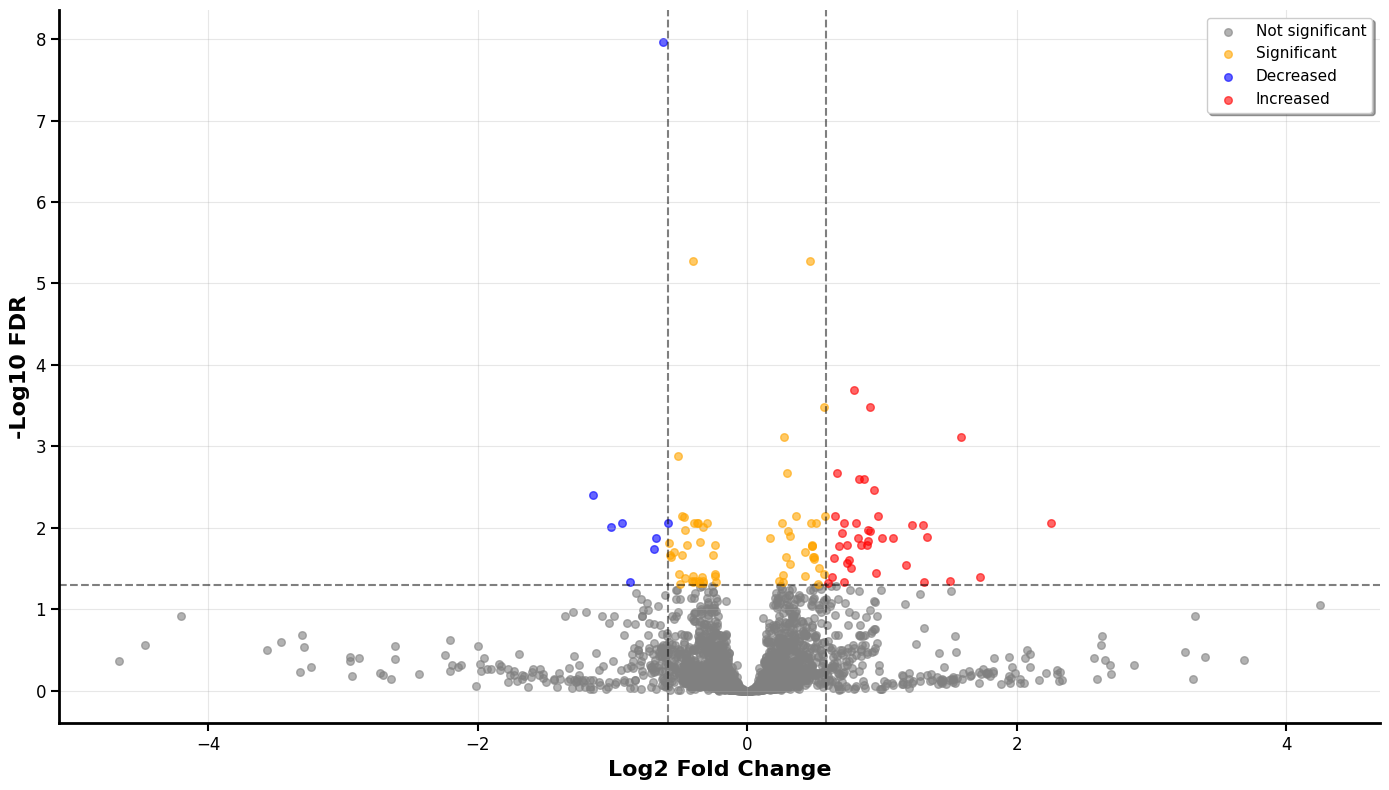

Volcano plot summary:
Total proteins: 2280
P-value type used: FDR (adjusted)
Significant (FDR < 0.05): 108
Up-regulated (FC > 0.5849625007211562, FDR < 0.05): 38
Down-regulated (FC < -0.5849625007211562, FDR < 0.05): 8


In [22]:
# Volcano Plot for Liraglutide
print("Creating Liraglutide volcano plot...")

ptk.visualization.plot_volcano(
    differential_df=liraglutide_results,
    fc_threshold=fold_change_threshold,
    p_threshold=p_value_threshold,
    figsize=(14, 8),
    title='Liraglutide Longitudinal Analysis: Proteins Changing Over Time',
    label_top_n=label_top_proteins,
    use_adjusted_pvalue=use_adjusted_pvalue,
    enable_pvalue_fallback=enable_pvalue_fallback,
    normalization_method=normalization_method
)

In [23]:
# Export Liraglutide Results
print("Exporting Liraglutide results...")

liraglutide_prefix = "Liraglutide-Longitudinal-Analysis"

# Export results
liraglutide_results_file = f"{liraglutide_prefix}_differential_results.csv"
liraglutide_results.to_csv(liraglutide_results_file, index=False)
print(f"✓ Liraglutide results exported to: {liraglutide_results_file}")

# Export significant proteins only (if any)
if use_adjusted_pvalue == "adjusted":
    liraglutide_sig = liraglutide_results[liraglutide_results['adj.P.Val'] < p_value_threshold]
else:
    liraglutide_sig = liraglutide_results[liraglutide_results['P.Value'] < p_value_threshold]

if len(liraglutide_sig) > 0:
    liraglutide_sig_file = f"{liraglutide_prefix}_significant_proteins.csv"
    liraglutide_sig.to_csv(liraglutide_sig_file, index=False)
    print(f"✓ {len(liraglutide_sig)} significant proteins exported to: {liraglutide_sig_file}")
else:
    print(f"  No significant proteins found at p < {p_value_threshold}")

Exporting Liraglutide results...
✓ Liraglutide results exported to: Liraglutide-Longitudinal-Analysis_differential_results.csv
✓ 108 significant proteins exported to: Liraglutide-Longitudinal-Analysis_significant_proteins.csv


# Comparison of Results

Compare significant proteins between Verapamil and Liraglutide analyses.

In [24]:
# ============================================================================
# COMPARE RESULTS BETWEEN COHORTS
# ============================================================================

print("="*80)
print("COMPARISON OF VERAPAMIL VS LIRAGLUTIDE")
print("="*80)

# Get significant proteins from each analysis
p_col = 'adj.P.Val' if use_adjusted_pvalue == "adjusted" else 'P.Value'

verapamil_sig_genes = set(verapamil_results[verapamil_results[p_col] < p_value_threshold]['Gene'].dropna())
liraglutide_sig_genes = set(liraglutide_results[liraglutide_results[p_col] < p_value_threshold]['Gene'].dropna())

print(f"\nSignificant proteins ({p_col} < {p_value_threshold}):")
print(f"  Verapamil: {len(verapamil_sig_genes)} proteins")
print(f"  Liraglutide: {len(liraglutide_sig_genes)} proteins")

# Find overlap
overlap_genes = verapamil_sig_genes & liraglutide_sig_genes
verapamil_only = verapamil_sig_genes - liraglutide_sig_genes
liraglutide_only = liraglutide_sig_genes - verapamil_sig_genes

print(f"\n  Overlapping proteins (significant in both): {len(overlap_genes)}")
print(f"  Verapamil-specific: {len(verapamil_only)}")
print(f"  Liraglutide-specific: {len(liraglutide_only)}")

if len(overlap_genes) > 0:
    print("\nOverlapping proteins:")
    for gene in sorted(overlap_genes):
        v_row = verapamil_results[verapamil_results['Gene'] == gene].iloc[0]
        l_row = liraglutide_results[liraglutide_results['Gene'] == gene].iloc[0]
        print(f"  {gene}: Verapamil p={v_row[p_col]:.2e}, Liraglutide p={l_row[p_col]:.2e}")

# Create summary DataFrame
comparison_summary = pd.DataFrame({
    'Category': ['Verapamil only', 'Liraglutide only', 'Both drugs', 'Total unique'],
    'Count': [len(verapamil_only), len(liraglutide_only), len(overlap_genes), 
              len(verapamil_sig_genes | liraglutide_sig_genes)]
})

print("\nSummary:")
display(comparison_summary)

COMPARISON OF VERAPAMIL VS LIRAGLUTIDE

Significant proteins (adj.P.Val < 0.05):
  Verapamil: 0 proteins
  Liraglutide: 108 proteins

  Overlapping proteins (significant in both): 0
  Verapamil-specific: 0
  Liraglutide-specific: 108

Summary:


Category  Count
0    Verapamil only      0
1  Liraglutide only    108
2        Both drugs      0
3      Total unique    108

In [25]:
print("="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print("\nExported files:")
print("  1. Verapamil-Longitudinal-Analysis_differential_results.csv")
print("  2. Liraglutide-Longitudinal-Analysis_differential_results.csv")
if len(verapamil_sig_genes) > 0:
    print("  3. Verapamil-Longitudinal-Analysis_significant_proteins.csv")
if len(liraglutide_sig_genes) > 0:
    print("  4. Liraglutide-Longitudinal-Analysis_significant_proteins.csv")
print("\n✓ All analyses completed successfully!")

ANALYSIS COMPLETE

Exported files:
  1. Verapamil-Longitudinal-Analysis_differential_results.csv
  2. Liraglutide-Longitudinal-Analysis_differential_results.csv
  4. Liraglutide-Longitudinal-Analysis_significant_proteins.csv

✓ All analyses completed successfully!


# Temporal Trend Clustering Analysis

Cluster proteins by their temporal trends across treatment weeks using K-means clustering.

**Approach**:
1. Calculate mean protein abundance at each timepoint (averaging across subjects)
2. Z-score normalize each protein's trajectory to focus on the shape/trend
3. Use K-means clustering to identify major temporal patterns
4. Filter to statistically significant proteins only
5. Visualize with heatmaps and parallel coordinate plots
6. Run gene set enrichment analysis (GSEA) via Enrichr API

**Features**:
- Uses the `temporal_clustering` module from `proteomics_toolkit`
- Automatic cluster naming based on trajectory patterns
- Publication-ready visualizations
- Integration with Enrichr for pathway enrichment analysis

In [26]:
# =============================================================================
# TEMPORAL CLUSTERING CONFIGURATION
# =============================================================================
# Force COMPLETE reload of the temporal_clustering module
import importlib
import sys

# Remove all cached versions of the module
modules_to_remove = [k for k in sys.modules.keys() if 'temporal_clustering' in k]
for mod in modules_to_remove:
    del sys.modules[mod]
    print(f"  Removed cached: {mod}")

# Also remove parent module to ensure fresh import
if 'proteomics_toolkit' in sys.modules:
    del sys.modules['proteomics_toolkit']
    print("  Removed cached: proteomics_toolkit")

# Now import fresh
from proteomics_toolkit.temporal_clustering import (
    TemporalClusteringConfig,
    run_temporal_analysis
)
print("✓ temporal_clustering module freshly imported")

# Configure temporal clustering analysis
temporal_config = TemporalClusteringConfig(
    # Automatic cluster detection using silhouette scores
    auto_detect_clusters=True,       # Automatically find optimal number of clusters
    min_clusters=2,                  # Minimum clusters to test
    max_clusters=8,                  # Maximum clusters to test
    clustering_method='kmeans',      # 'kmeans' or 'hierarchical'
    random_seed=42,
    
    # Significance thresholds
    p_value_threshold=0.05,          # Only include significant proteins
    use_adjusted_pvalue=False,       # Use raw p-value (set True for FDR)
    min_fold_change=0.0,             # Minimum fold change filter
    
    # Enrichment settings (Enrichr API)
    enrichr_libraries=[
        'GO_Biological_Process_2023',
        'GO_Molecular_Function_2023',
        'KEGG_2021_Human',
        'Reactome_2022',
        'WikiPathway_2023_Human'
    ],
    enrichment_pvalue_cutoff=0.05,
    enrichment_top_n=20,
    min_genes_for_enrichment=5,
    
    # Visualization settings
    figsize=(14, 10),
    linewidth=2.0,                   # Line thickness for plots
    alpha=0.4,                       # Transparency for individual lines
    cmap='RdBu_r'                    # Colormap for heatmaps
)

print("✓ Temporal clustering configuration loaded")
print(f"   Auto-detect clusters: {temporal_config.auto_detect_clusters}")
print(f"   Cluster range: {temporal_config.min_clusters} to {temporal_config.max_clusters}")
print("   Method: Silhouette score optimization")
print(f"   P-value threshold: {temporal_config.p_value_threshold}")
print(f"   Enrichment libraries: {len(temporal_config.enrichr_libraries)}")

  Removed cached: proteomics_toolkit.temporal_clustering
  Removed cached: proteomics_toolkit
✓ temporal_clustering module freshly imported
✓ Temporal clustering configuration loaded
   Auto-detect clusters: True
   Cluster range: 2 to 8
   Method: Silhouette score optimization
   P-value threshold: 0.05
   Enrichment libraries: 5


## Verapamil Temporal Analysis

Run temporal trend clustering analysis for Verapamil-treated samples.

In [27]:
# Run Verapamil temporal analysis
verapamil_temporal_results = run_temporal_analysis(
    data_df=normalized_data,
    metadata_dict=verapamil_metadata,
    stats_df=verapamil_results,  # Statistical results from differential analysis
    treatment_name='Verapamil',
    config=temporal_config,
    run_enrichment=True,  # Run gene set enrichment via Enrichr
    output_prefix='Verapamil-Temporal-Analysis'  # Export results to CSV
)

VERAPAMIL: TEMPORAL CLUSTERING ANALYSIS

1. Calculating temporal means (within-subject Z-score normalization)...
   Subject column: BRI Subject ID

1. Calculating temporal means (within-subject Z-score normalization)...
   Subject column: BRI Subject ID
   Timepoints: [0.0, 2.0, 4.0, 6.0, 12.0]
   Proteins: 2280

2. Auto-detecting optimal number of clusters (range: 2-8)...
   Determining optimal number of clusters...
   Timepoints: [0.0, 2.0, 4.0, 6.0, 12.0]
   Proteins: 2280

2. Auto-detecting optimal number of clusters (range: 2-8)...
   Determining optimal number of clusters...
   Optimal clusters: 5
   Optimal clusters: 5
   Final cluster count: 5
   Cluster distribution:
     Cluster 1: 777 proteins
     Cluster 2: 403 proteins
     Cluster 3: 352 proteins
     Cluster 4: 454 proteins
     Cluster 5: 294 proteins

3. Merging with statistical results...
   (Statistical testing was performed in the differential analysis step,
    typically using limma for longitudinal proteomics dat

VERAPAMIL: Significant Proteins by Cluster

Available columns: ['Protein', 'Gene', 'Week_0.0', 'Week_2.0', 'Week_4.0', 'Week_6.0', 'Week_12.0', 'Cluster', 'Cluster_Name', 'logFC', 'P.Value', 'adj.P.Val']

Cluster Distribution (327 significant proteins):

  Cluster 3: 86 proteins
    - IGFBP1: logFC=1.26, p=0.0291
    - UBAC1: logFC=1.10, p=0.0283
    - RPS17: logFC=1.08, p=0.0020
    - SPTA1: logFC=1.05, p=0.0125
    - SNCA: logFC=1.02, p=0.0108

  Cluster 4: 51 proteins
    - STAT1: logFC=0.67, p=0.0384
    - CNP: logFC=-0.20, p=0.0076
    - GNAI2: logFC=-0.24, p=0.0318
    - B2M: logFC=-0.25, p=0.0457
    - HSPE1: logFC=-0.26, p=0.0137

  Cluster 5: 17 proteins
    - ZBTB45: logFC=0.66, p=0.0360
    - CSNK2A3 / CSNK2A1: logFC=0.37, p=0.0222
    - EEF1G: logFC=-0.22, p=0.0245
    - GPC6: logFC=-0.34, p=0.0391
    - ENTPD5: logFC=-0.38, p=0.0044

  Cluster 2: 49 proteins
    - RAB3GAP2: logFC=0.89, p=0.0084
    - CLTA: logFC=0.83, p=0.0481
    - MYL1 / MYL3: logFC=0.62, p=0.0157
    - 

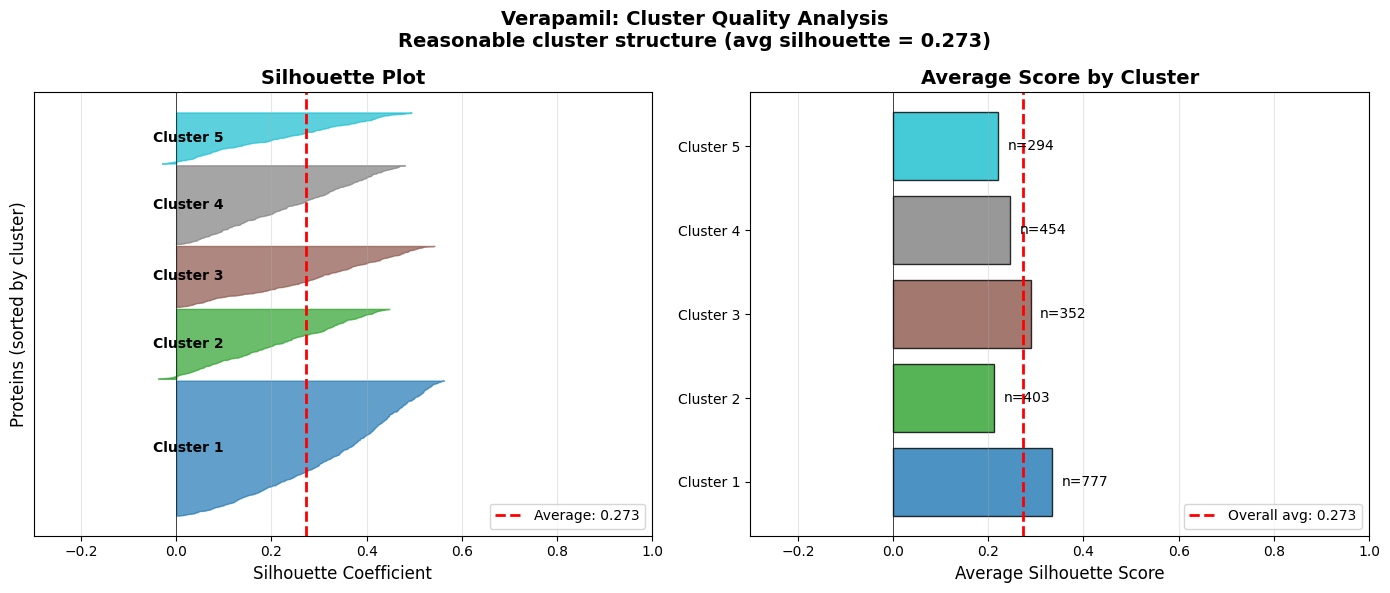


--- Cluster Heatmap ---


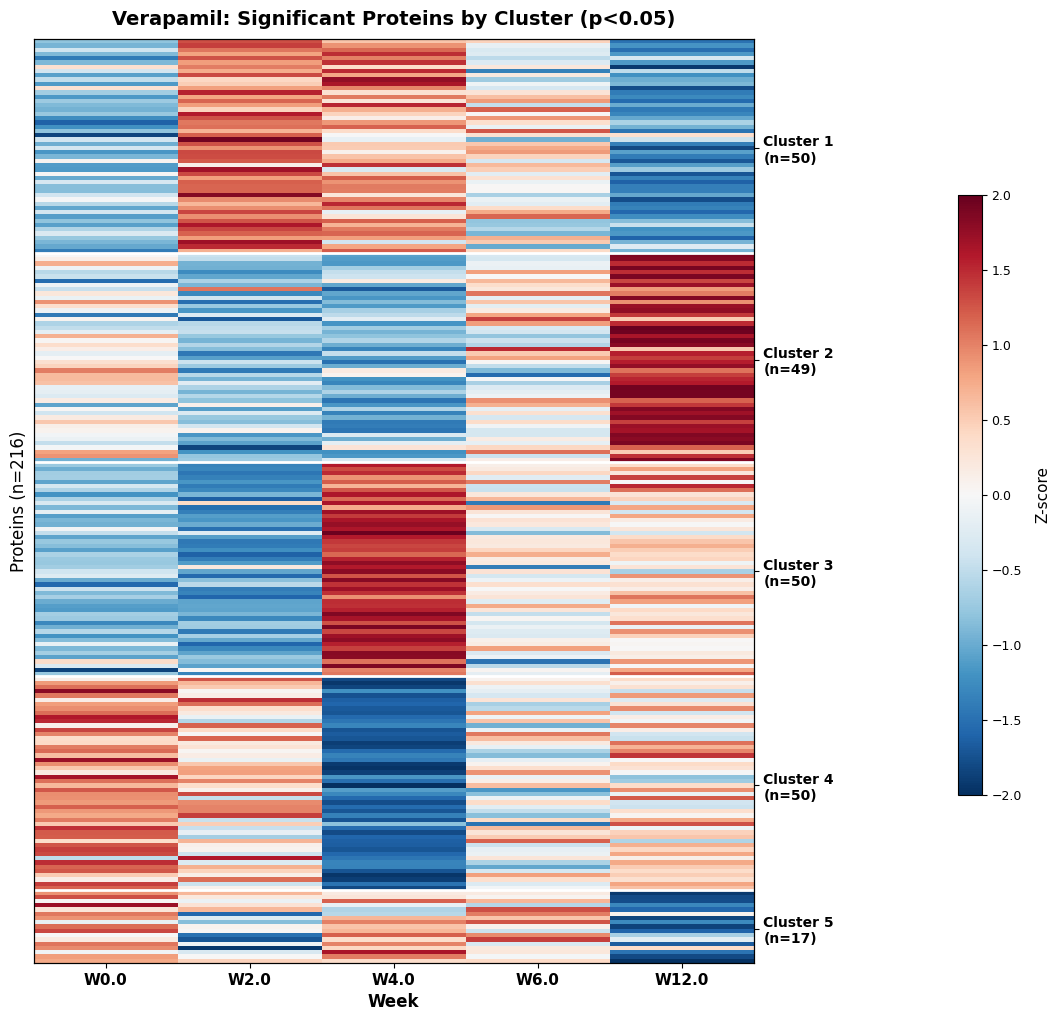

In [28]:
# Display Verapamil significant proteins by cluster
print("="*80)
print("VERAPAMIL: Significant Proteins by Cluster")
print("="*80)

verapamil_sig_df = verapamil_temporal_results['significant_df']
print(f"\nAvailable columns: {list(verapamil_sig_df.columns)}")

if 'Cluster_Name' in verapamil_sig_df.columns:
    print(f"\nCluster Distribution ({len(verapamil_sig_df)} significant proteins):\n")
    for cluster in verapamil_sig_df['Cluster_Name'].unique():
        cluster_data = verapamil_sig_df[verapamil_sig_df['Cluster_Name'] == cluster]
        print(f"  {cluster}: {len(cluster_data)} proteins")
        # Show top 5 genes by logFC (fold change)
        if 'logFC' in cluster_data.columns:
            # Use P.Value (with dot) - the column name from limma results
            p_col = 'P.Value' if 'P.Value' in cluster_data.columns else 'P_Value'
            cols_to_show = ['Gene', 'logFC']
            if p_col in cluster_data.columns:
                cols_to_show.append(p_col)
            top_genes = cluster_data.nlargest(5, 'logFC')[cols_to_show]
            for _, row in top_genes.iterrows():
                p_val = row.get(p_col, 'N/A')
                if isinstance(p_val, float):
                    print(f"    - {row['Gene']}: logFC={row['logFC']:.2f}, p={p_val:.4f}")
                else:
                    print(f"    - {row['Gene']}: logFC={row['logFC']:.2f}")
        print()
else:
    print("No cluster assignments found.")

# Display the silhouette plot (cluster quality analysis)
print("\n--- Cluster Quality Analysis (Silhouette Plot) ---")
if 'fig_silhouette' in verapamil_temporal_results:
    display(verapamil_temporal_results['fig_silhouette'])
else:
    print("Silhouette plot not available - re-run temporal analysis with updated toolkit")

# Display the heatmap
print("\n--- Cluster Heatmap ---")
if 'fig_heatmap' in verapamil_temporal_results:
    display(verapamil_temporal_results['fig_heatmap'])

Verapamil: Temporal Patterns (Significant Proteins)


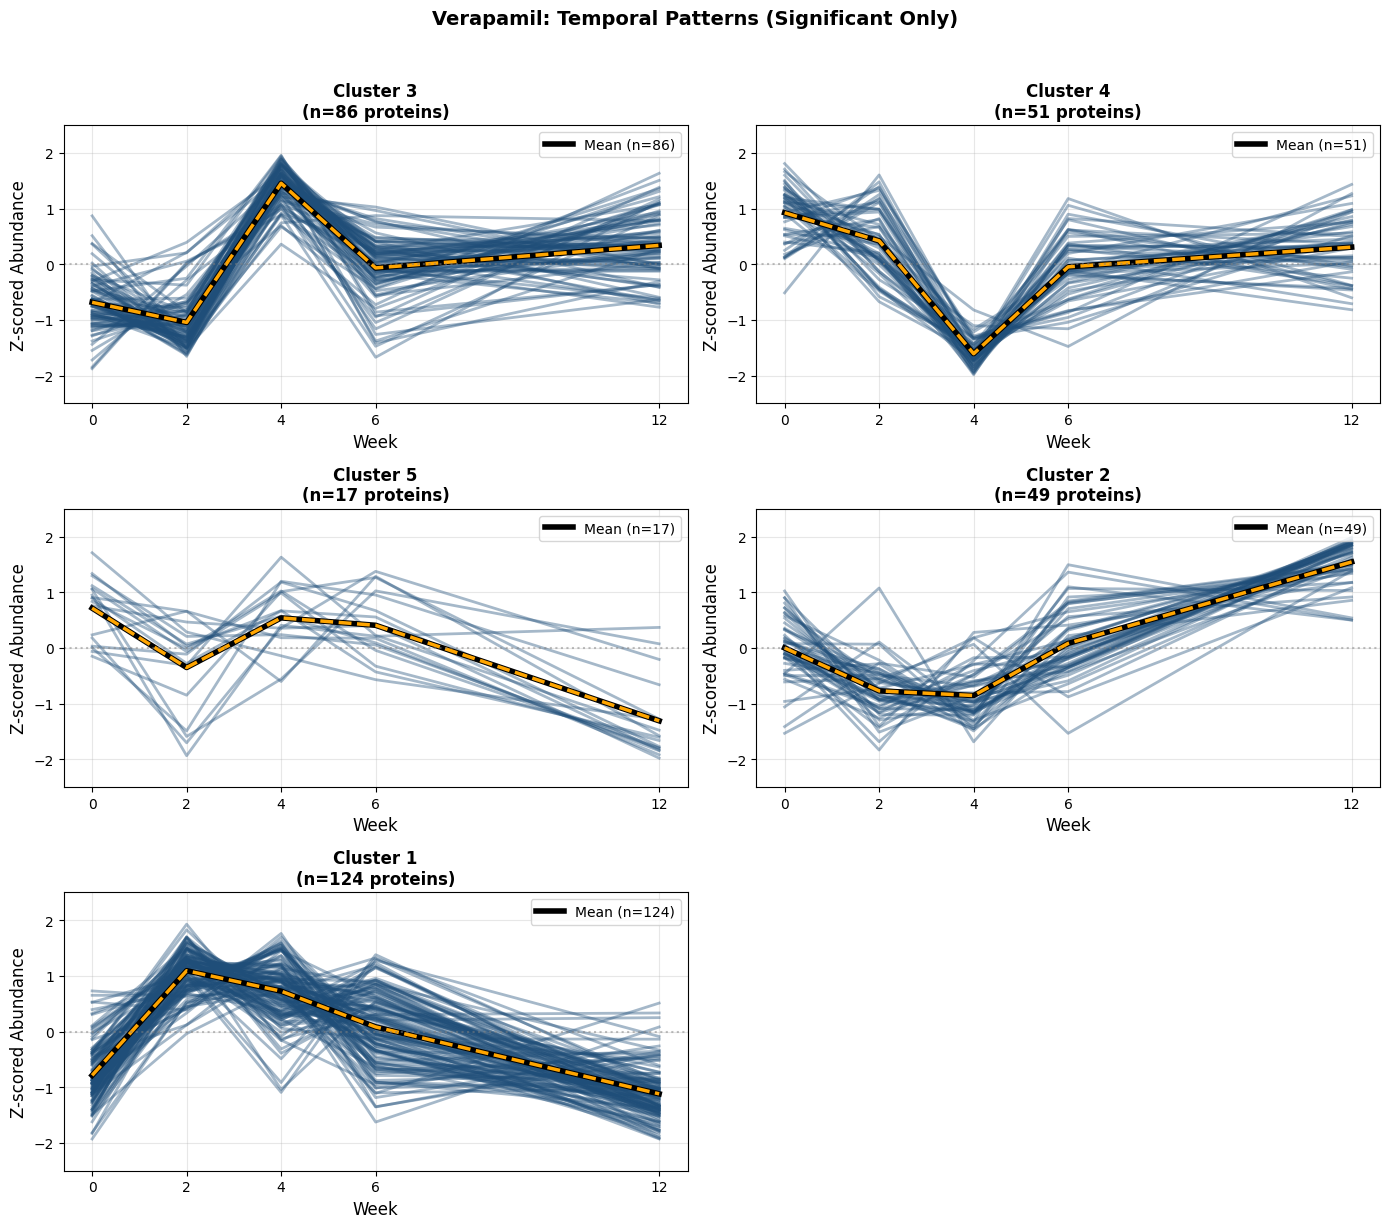

In [29]:
# Display Verapamil parallel coordinate plot
print("Verapamil: Temporal Patterns (Significant Proteins)")
if 'fig_parallel' in verapamil_temporal_results:
    display(verapamil_temporal_results['fig_parallel'])

In [30]:
# Display Verapamil enrichment results
print("="*80)
print("VERAPAMIL: Gene Set Enrichment Results by Cluster")
print("="*80)

if 'enrichment_results' in verapamil_temporal_results:
    enrichment = verapamil_temporal_results['enrichment_results']
    for cluster_name, enrich_df in enrichment.items():
        print(f"\n{cluster_name}:")
        if not enrich_df.empty:
            top_terms = enrich_df.nlargest(10, 'Combined_Score')[['Term', 'Combined_Score', 'Adj_P_Value', 'Library']]
            for _, row in top_terms.iterrows():
                print(f"  - {row['Term'][:60]} (score={row['Combined_Score']:.1f}, p={row['Adj_P_Value']:.2e})")
        else:
            print("  No significant enrichment found")
else:
    print("Enrichment analysis not run - set run_enrichment=True")

# Display enrichment comparison plot if available
if 'fig_enrichment_comparison' in verapamil_temporal_results:
    print("\n")
    verapamil_temporal_results['fig_enrichment_comparison']

VERAPAMIL: Gene Set Enrichment Results by Cluster

Cluster 3:
  - Proteasome (score=42934.2, p=1.02e-46)
  - Cross-presentation Of Soluble Exogenous Antigens (Endosomes) (score=38669.1, p=1.04e-45)
  - Regulation Of Activated PAK-2p34 By Proteasome Mediated Degr (score=36814.5, p=1.11e-45)
  - Regulation Of Ornithine Decarboxylase (ODC) R-HSA-350562 (score=35115.1, p=1.50e-45)
  - Ubiquitin Mediated Degradation Of Phosphorylated Cdc25A R-HS (score=33552.5, p=1.50e-45)
  - Ubiquitin-dependent Degradation Of Cyclin D R-HSA-75815 (score=33552.5, p=1.50e-45)
  - GSK3B And BTRC:CUL1-mediated-degradation Of NFE2L2 R-HSA-976 (score=33552.5, p=1.50e-45)
  - Autodegradation Of E3 Ubiquitin Ligase COP1 R-HSA-349425 (score=33552.5, p=1.50e-45)
  - Vpu Mediated Degradation Of CD4 R-HSA-180534 (score=33552.5, p=1.50e-45)
  - Hh Mutants Are Degraded By ERAD R-HSA-5362768 (score=32732.9, p=7.19e-46)

Cluster 4:
  - Thromboxane Signaling Thru TP Receptor R-HSA-428930 (score=3596.4, p=1.35e-09)
  - Sig

## Liraglutide Temporal Analysis

Run temporal trend clustering analysis for Liraglutide-treated samples.

In [31]:
# Run Liraglutide temporal analysis
liraglutide_temporal_results = run_temporal_analysis(
    data_df=normalized_data,
    metadata_dict=liraglutide_metadata,
    stats_df=liraglutide_results,  # Statistical results from differential analysis
    treatment_name='Liraglutide',
    config=temporal_config,
    run_enrichment=True,  # Run gene set enrichment via Enrichr
    output_prefix='Liraglutide-Temporal-Analysis'  # Export results to CSV
)

LIRAGLUTIDE: TEMPORAL CLUSTERING ANALYSIS

1. Calculating temporal means (within-subject Z-score normalization)...
   Subject column: BRI Subject ID

1. Calculating temporal means (within-subject Z-score normalization)...
   Subject column: BRI Subject ID
   Timepoints: [-2.0, 4.0, 8.0]
   Proteins: 2280

2. Auto-detecting optimal number of clusters (range: 2-8)...
   Determining optimal number of clusters...
   Timepoints: [-2.0, 4.0, 8.0]
   Proteins: 2280

2. Auto-detecting optimal number of clusters (range: 2-8)...
   Determining optimal number of clusters...
   Optimal clusters: 8
   Optimal clusters: 8
   Final cluster count: 8
   Cluster distribution:
     Cluster 1: 349 proteins
     Cluster 2: 359 proteins
     Cluster 3: 223 proteins
     Cluster 4: 254 proteins
     Cluster 5: 272 proteins
     Cluster 6: 246 proteins
     Cluster 7: 298 proteins
     Cluster 8: 279 proteins

3. Merging with statistical results...
   (Statistical testing was performed in the differential ana

LIRAGLUTIDE: Significant Proteins by Cluster

Cluster Distribution (438 significant proteins):

  Cluster 1: 104 proteins
    - IGHV1-69-2: logFC=2.63, p=0.0358
    - FN1: logFC=2.26, p=0.0001
    - CKMT1A: logFC=1.73, p=0.0015
    - ECM1: logFC=1.58, p=0.0000
    - FGB: logFC=1.52, p=0.0033

  Cluster 2: 127 proteins
    - GZMB: logFC=0.18, p=0.0467
    - DKK3: logFC=0.15, p=0.0483
    - TXNDC15: logFC=0.14, p=0.0458
    - HSPG2: logFC=0.12, p=0.0143
    - NEO1: logFC=-0.16, p=0.0327

  Cluster 8: 53 proteins
    - UTRN: logFC=3.32, p=0.0131
    - IGKV1D-37 / IGKV1-37: logFC=1.29, p=0.0039
    - DDX39B / DDX39A: logFC=1.18, p=0.0010
    - SRSF3: logFC=0.99, p=0.0031
    - SRSF2 / SRSF8: logFC=0.91, p=0.0095

  Cluster 3: 9 proteins
    - PIP4K2B: logFC=-0.24, p=0.0305
    - PPP1CB: logFC=-0.29, p=0.0219
    - PPP2R1A: logFC=-0.34, p=0.0099
    - DNAJA2: logFC=-0.39, p=0.0103
    - RNASE3: logFC=-0.53, p=0.0344

  Cluster 5: 14 proteins
    - GATD3: logFC=4.25, p=0.0071
    - H2AC21: l

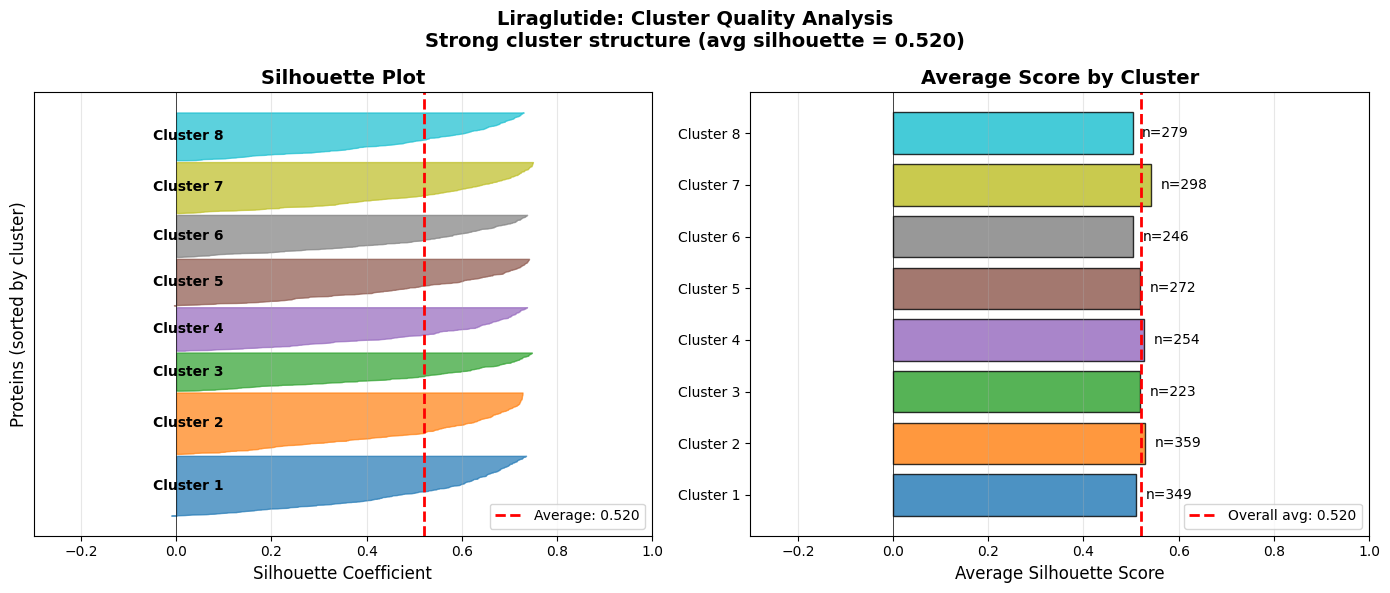


--- Cluster Heatmap ---


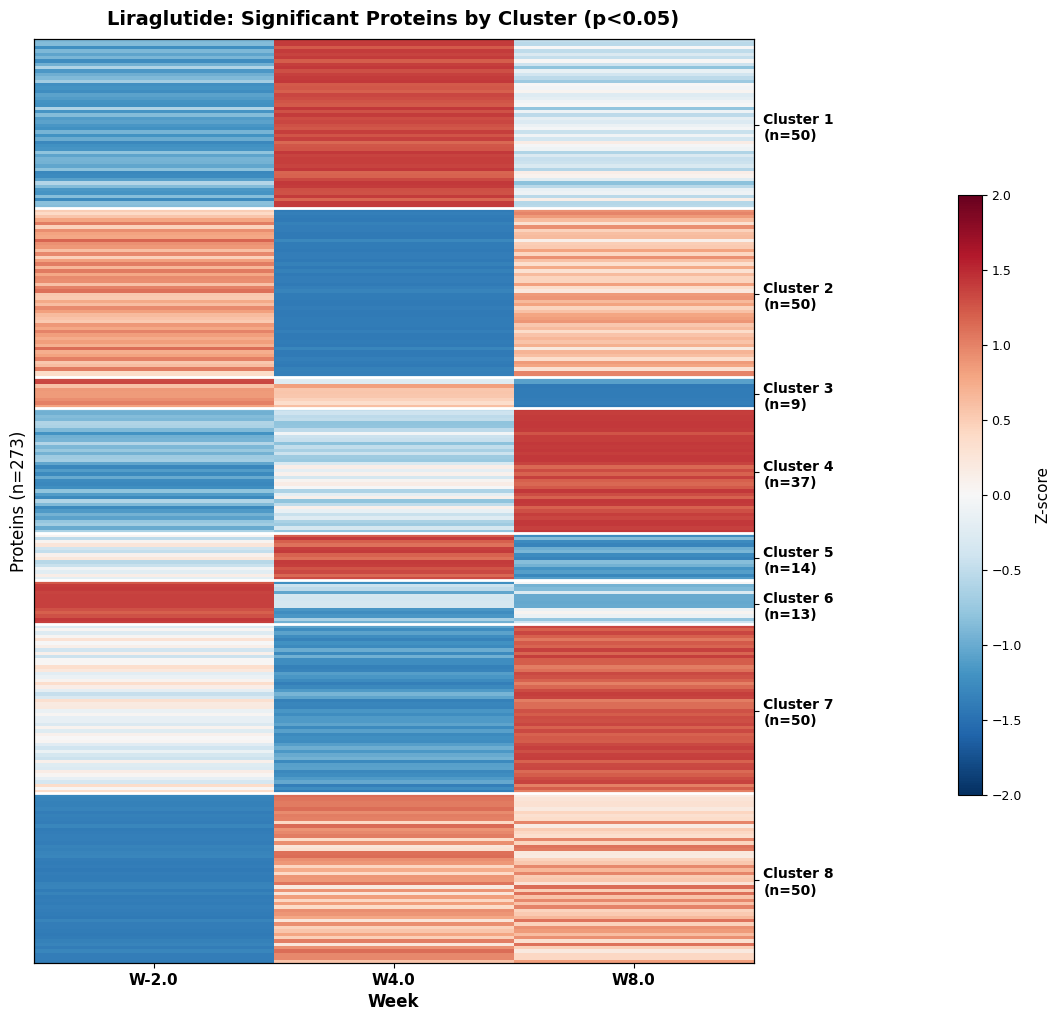

In [32]:
# Display Liraglutide significant proteins by cluster
print("="*80)
print("LIRAGLUTIDE: Significant Proteins by Cluster")
print("="*80)

liraglutide_sig_df = liraglutide_temporal_results['significant_df']

if 'Cluster_Name' in liraglutide_sig_df.columns:
    print(f"\nCluster Distribution ({len(liraglutide_sig_df)} significant proteins):\n")
    for cluster in liraglutide_sig_df['Cluster_Name'].unique():
        cluster_data = liraglutide_sig_df[liraglutide_sig_df['Cluster_Name'] == cluster]
        print(f"  {cluster}: {len(cluster_data)} proteins")
        # Show top 5 genes by logFC
        if 'logFC' in cluster_data.columns:
            # Use P.Value (with dot) - the column name from limma results
            p_col = 'P.Value' if 'P.Value' in cluster_data.columns else 'P_Value'
            cols_to_show = ['Gene', 'logFC']
            if p_col in cluster_data.columns:
                cols_to_show.append(p_col)
            top_genes = cluster_data.nlargest(5, 'logFC')[cols_to_show]
            for _, row in top_genes.iterrows():
                p_val = row.get(p_col, 'N/A')
                if isinstance(p_val, float):
                    print(f"    - {row['Gene']}: logFC={row['logFC']:.2f}, p={p_val:.4f}")
                else:
                    print(f"    - {row['Gene']}: logFC={row['logFC']:.2f}")
        print()
else:
    print("No cluster assignments found.")

# Display the silhouette plot (cluster quality analysis)
print("\n--- Cluster Quality Analysis (Silhouette Plot) ---")
if 'fig_silhouette' in liraglutide_temporal_results:
    display(liraglutide_temporal_results['fig_silhouette'])
else:
    print("Silhouette plot not available - re-run temporal analysis with updated toolkit")

# Display the heatmap
print("\n--- Cluster Heatmap ---")
if 'fig_heatmap' in liraglutide_temporal_results:
    display(liraglutide_temporal_results['fig_heatmap'])

Liraglutide: Temporal Patterns (Significant Proteins)


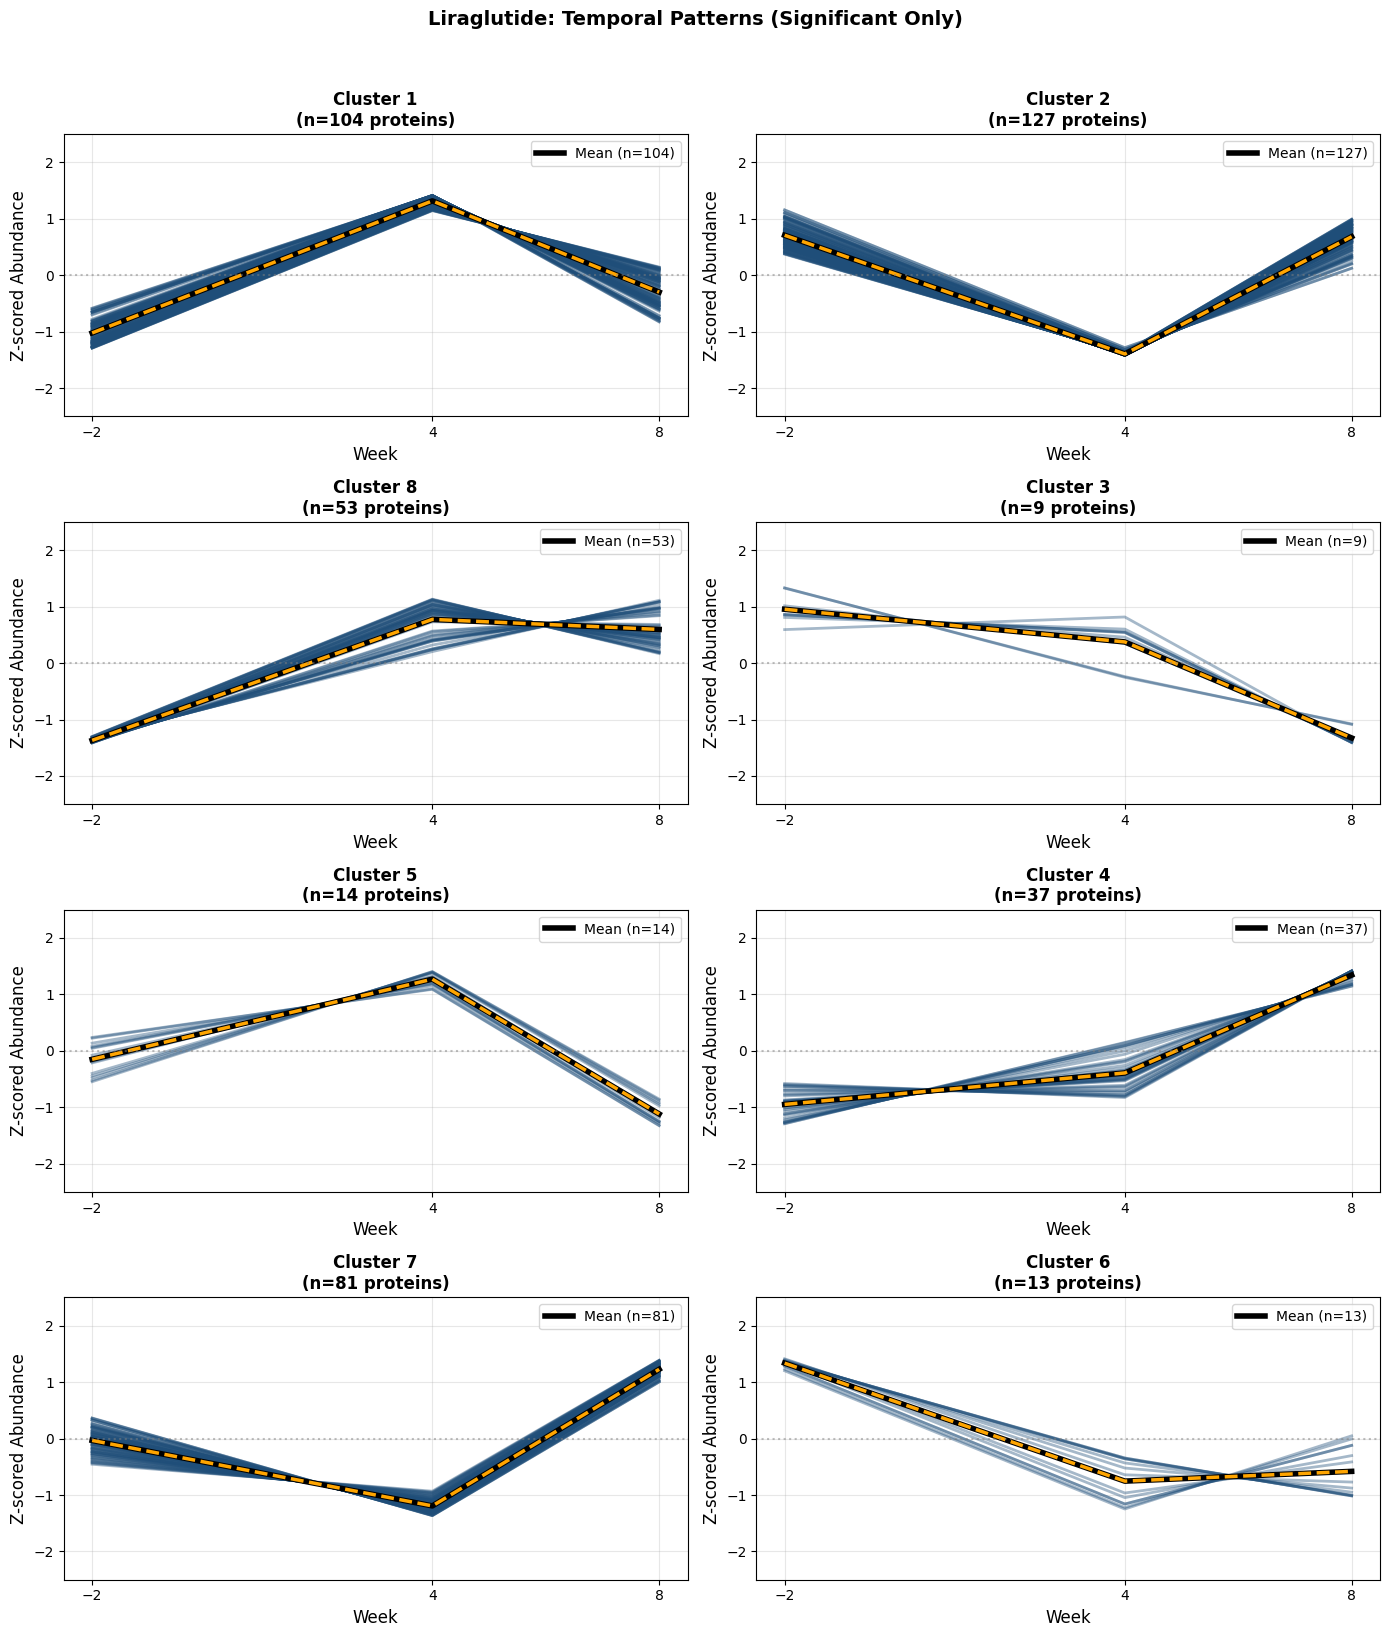

In [33]:
# Display Liraglutide parallel coordinate plot
print("Liraglutide: Temporal Patterns (Significant Proteins)")
if 'fig_parallel' in liraglutide_temporal_results:
    display(liraglutide_temporal_results['fig_parallel'])

In [34]:
# Display Liraglutide enrichment results
print("="*80)
print("LIRAGLUTIDE: Gene Set Enrichment Results by Cluster")
print("="*80)

if 'enrichment_results' in liraglutide_temporal_results:
    enrichment = liraglutide_temporal_results['enrichment_results']
    for cluster_name, enrich_df in enrichment.items():
        print(f"\n{cluster_name}:")
        if not enrich_df.empty:
            top_terms = enrich_df.nlargest(10, 'Combined_Score')[['Term', 'Combined_Score', 'Adj_P_Value', 'Library']]
            for _, row in top_terms.iterrows():
                print(f"  - {row['Term'][:60]} (score={row['Combined_Score']:.1f}, p={row['Adj_P_Value']:.2e})")
        else:
            print("  No significant enrichment found")
else:
    print("Enrichment analysis not run - set run_enrichment=True")

# Display enrichment comparison plot if available
if 'fig_enrichment_comparison' in liraglutide_temporal_results:
    print("\n")
    liraglutide_temporal_results['fig_enrichment_comparison']

LIRAGLUTIDE: Gene Set Enrichment Results by Cluster

Cluster 1:
  - COVID 19 Thrombosis And Anticoagulation WP4927 (score=36248.8, p=4.52e-12)
  - Classical Antibody-Mediated Complement Activation R-HSA-1736 (score=7318.8, p=1.88e-07)
  - Blood Clotting Cascade WP272 (score=5017.1, p=4.65e-14)
  - Complement and coagulation cascades (score=4598.2, p=4.10e-26)
  - Blood Coagulation, Fibrin Clot Formation (GO:0072378) (score=3611.4, p=1.08e-08)
  - Protein Activation Cascade (GO:0072376) (score=3611.4, p=1.08e-08)
  - Plasminogen Activation (GO:0031639) (score=3354.2, p=3.95e-06)
  - Synapse Pruning (GO:0098883) (score=3354.2, p=3.95e-06)
  - Complement And Coagulation Cascades WP558 (score=3142.6, p=5.44e-18)
  - Fibrinolysis (GO:0042730) (score=2833.7, p=4.33e-07)

Cluster 2:
  - Regulation Of Basement Membrane Organization (GO:0110011) (score=12072.0, p=2.04e-06)
  - Oxygen Transport (GO:0015671) (score=3236.2, p=1.24e-06)
  - Laminin Interactions R-HSA-3000157 (score=2679.4, p=1.11e-

## Summary: Drug Treatment Comparison

Compare temporal clustering results between Verapamil and Liraglutide treatments.

In [35]:
# Compare temporal clustering results between treatments
print("="*80)
print("TEMPORAL CLUSTERING COMPARISON: Verapamil vs Liraglutide")
print("="*80)

# Summary statistics
vera_sig = verapamil_temporal_results['significant_df']
lira_sig = liraglutide_temporal_results['significant_df']

print(f"\n{'Metric':<40} {'Verapamil':<15} {'Liraglutide':<15}")
print("-"*70)
print(f"{'Significant proteins':<40} {len(vera_sig):<15} {len(lira_sig):<15}")

if 'Cluster_Name' in vera_sig.columns and 'Cluster_Name' in lira_sig.columns:
    print(f"{'Number of clusters':<40} {vera_sig['Cluster_Name'].nunique():<15} {lira_sig['Cluster_Name'].nunique():<15}")
    
    # Cluster breakdown
    print("\nCluster Distribution:")
    print("-"*70)
    
    all_clusters = set(vera_sig['Cluster_Name'].unique()) | set(lira_sig['Cluster_Name'].unique())
    for cluster in sorted(all_clusters):
        vera_count = len(vera_sig[vera_sig['Cluster_Name'] == cluster]) if cluster in vera_sig['Cluster_Name'].values else 0
        lira_count = len(lira_sig[lira_sig['Cluster_Name'] == cluster]) if cluster in lira_sig['Cluster_Name'].values else 0
        print(f"  {cluster:<38} {vera_count:<15} {lira_count:<15}")

# Gene overlap analysis
vera_genes = set(vera_sig['Gene'].dropna().unique())
lira_genes = set(lira_sig['Gene'].dropna().unique())
overlap_genes = vera_genes & lira_genes
vera_only = vera_genes - lira_genes
lira_only = lira_genes - vera_genes

print("\nGene Overlap Analysis:")
print("-"*70)
print(f"  Genes significant in both:      {len(overlap_genes)}")
print(f"  Verapamil-specific genes:       {len(vera_only)}")
print(f"  Liraglutide-specific genes:     {len(lira_only)}")

if len(overlap_genes) > 0 and len(overlap_genes) <= 20:
    print(f"\n  Shared genes: {', '.join(sorted(overlap_genes))}")
elif len(overlap_genes) > 20:
    print(f"\n  Top shared genes: {', '.join(sorted(overlap_genes)[:20])}...")

print("\n" + "="*80)
print("✓ Temporal clustering analysis complete for both treatments")
print("="*80)

TEMPORAL CLUSTERING COMPARISON: Verapamil vs Liraglutide

Metric                                   Verapamil       Liraglutide    
----------------------------------------------------------------------
Significant proteins                     327             438            
Number of clusters                       5               8              

Cluster Distribution:
----------------------------------------------------------------------
  Cluster 1                              124             104            
  Cluster 2                              49              127            
  Cluster 3                              86              9              
  Cluster 4                              51              37             
  Cluster 5                              17              14             
  Cluster 6                              0               13             
  Cluster 7                              0               81             
  Cluster 8                              0     